In [2]:
import pandas as pd
import numpy as np 

In [3]:
# sklearn에서 캘리포니아 집값 예측 데이터셋 가져오기
from sklearn.datasets import fetch_california_housing

# numpy에서 소수점 4째 자리까지만 출력
np.set_printoptions(precision=4, suppress=True)

data = fetch_california_housing()

In [4]:
# data의 특성을 확인
# 행의 갯수 : 20640
# 열의 특성 : 8 numeric
#print(data['DESCR'])

MedInc	: 구역 내 가구의 중간 소득 <br>
HouseAge :	구역 내 주택 연령의 중간값 <br>
AveRooms :	가구당 평균 방 개수<br>
AveBedrms :	가구당 평균 침실 개수<br>
Population :	구역 내 총 인구수<br>
AveOccup :	가구당 평균 인원수<br>
Latitude :	구역의 위도<br>
Longitude : 	구역의 경도<br>

In [5]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df["MedHouseVal"] = data.target

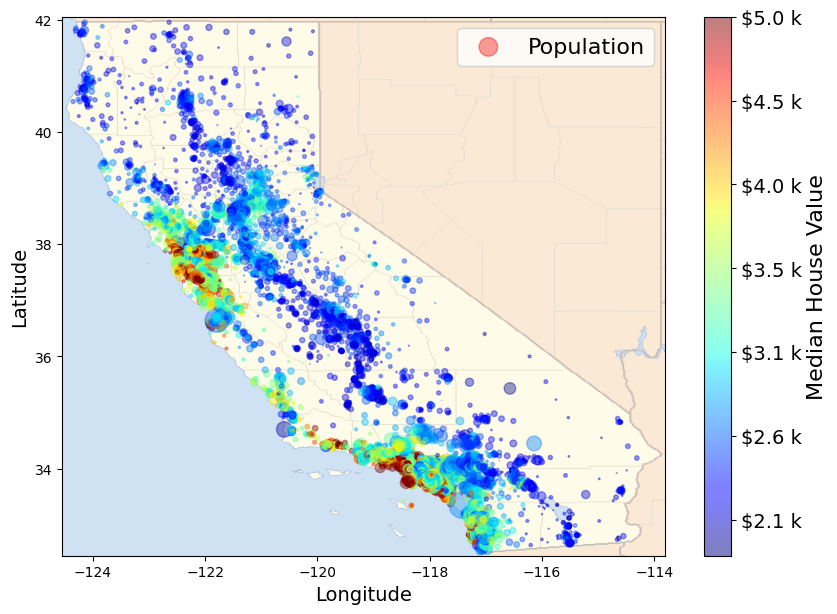

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib.request

# 캘리포니아 지도 이미지 다운로드 (GitHub에서 바로 다운로드)
url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/images/end_to_end_project/california.png"
filename = "california.png"
print("Downloading california.png...")
urllib.request.urlretrieve(url, filename)
california_img = mpimg.imread(filename)

# 지도 시각화
ax = df.plot(kind="scatter", x="Longitude", y="Latitude", figsize=(10,7),
             s=df['Population']/100, label="Population",
             c="MedHouseVal", cmap=plt.get_cmap("jet"),
             colorbar=False, alpha=0.4)

# 지도 이미지 오버레이 (coordinates based on the image extent)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

# 가격 컬러바 추가
prices = df["MedHouseVal"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%.1f k"%(v) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

In [7]:
df.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422

### 데이터 분할

In [8]:
# train_test_split
from sklearn.model_selection import train_test_split

# 데이터셋 분할
data_train, data_test, target_train, target_test = train_test_split(df.drop("MedHouseVal", axis=1), df["MedHouseVal"], test_size=0.2, random_state=42)

# 데이터셋 확인
print("Training set size:", len(data_train))
print("Test set size:", len(data_test))


Training set size: 16512
Test set size: 4128


In [9]:
# 회귀에 대한 평가 지표
# MSE, RMSE, MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

# plot_predictions : 예측값과 실제값을 산점도로 비교하여 시각화
def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': actual})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

# mse 기준으로 모델의 성능 평가를 해주는 함수
def mse_eval(name_, pred, actual):
    global predictions
    global colors

    # 산점도를 그려주고(예측값, 정답값)
    plot_predictions(name_, pred, actual)

    # mse 계산 출력
    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse

    # 모델별 성능을 비교하기 위해 sorted
    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df)
    
    # 모델들을 비교해서 barh로 그려준다.
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['mse'])
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('MSE Error', fontsize=18)
    plt.xlim(min_, max_)
    
    plt.show()

# 리스트에 있는 모델중에 하나를 삭제하는 함수
def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

### Model 1. LinearRegression

In [11]:
from sklearn.linear_model import LinearRegression

입력되는 변수(Variable)의 갯수가 beta값의 갯수를 좌우한다.

$$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + \beta_5 x_5 + \beta_6 x_6 + \beta_7 x_7 + \beta_8 x_8$$

$$\mathbf{ h_\theta(x_{i}) = \theta_0+\theta_1 MedInc + \theta_2 HouseAge + \theta_3 AveRooms + \theta_4 AveBedrms + \theta_5 Population + \theta_6 AveOccup + \theta_7 Latitude + \theta_8 Longitude }$$

In [12]:
# data_train, data_test, target_train, target_test

# 1. 모델 생성
model = LinearRegression()

# 2. 모델 학습
model.fit(data_train, target_train)

# 3. 모델 예측 : 예측값을 받아올때 
y_pred = model.predict(data_test)

# 4. 모델 평가
mse = mean_squared_error(target_test, y_pred)
mse

0.5558915986952435

In [13]:
print(model.coef_)
print(model.intercept_)

[ 0.4487  0.0097 -0.1233  0.7831 -0.     -0.0035 -0.4198 -0.4337]
-37.023277706064256


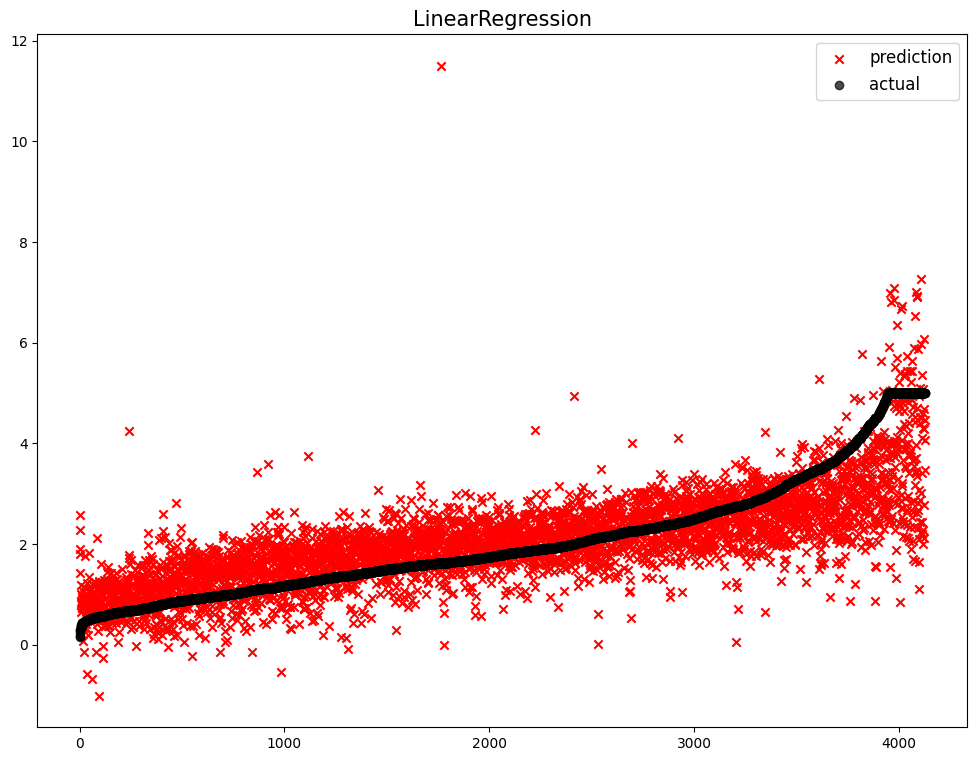

              model       mse
0  LinearRegression  0.555892


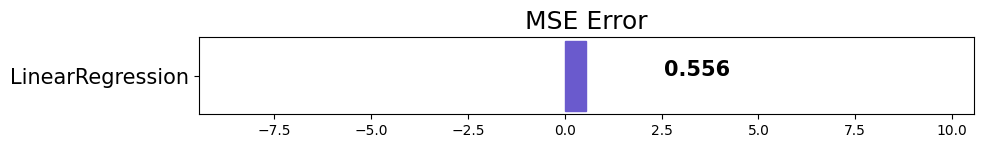

In [14]:
# mse_eval 함수를 사용 : 모델을 리스트에 추가할때 모델명
mse_eval('LinearRegression', y_pred, target_test)

## 규제(Regularization , =penalty)
### L1 penalty, L2 penalty

**라쏘(Lasso) - L1 규제**  
$Error=MSE+α|w|$

**릿지(Ridge) - L2 규제** <br>
$Error=MSE+αw^2$ 


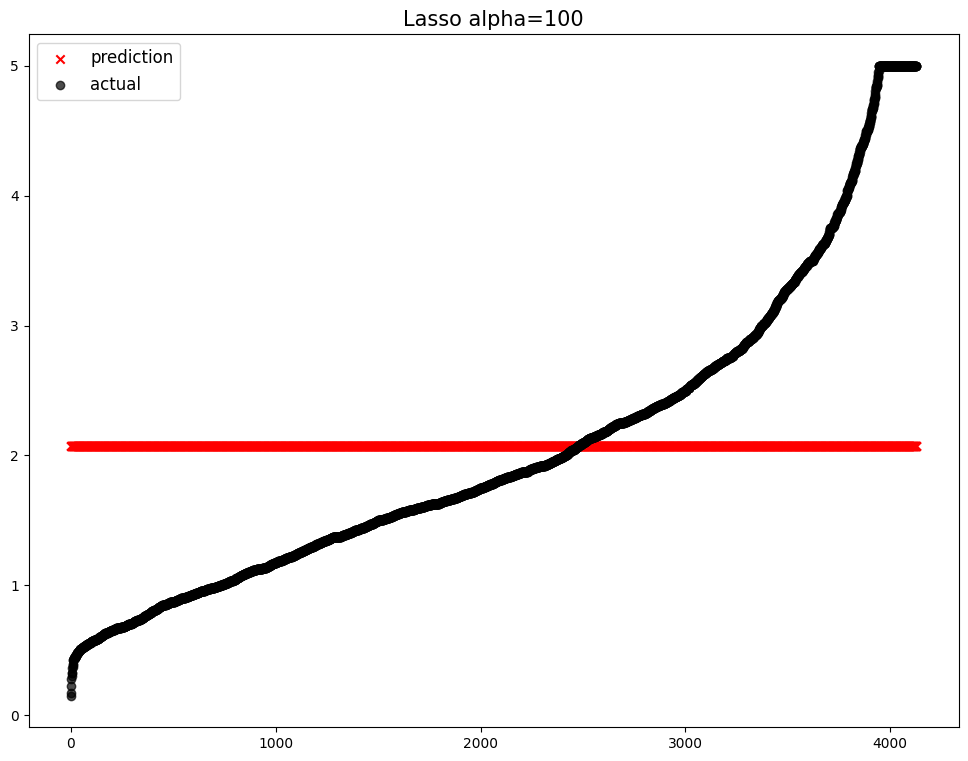

              model       mse
0   Lasso alpha=100  1.310696
1  LinearRegression  0.555892


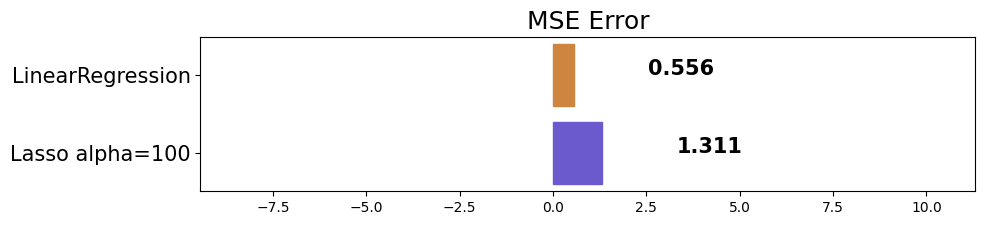

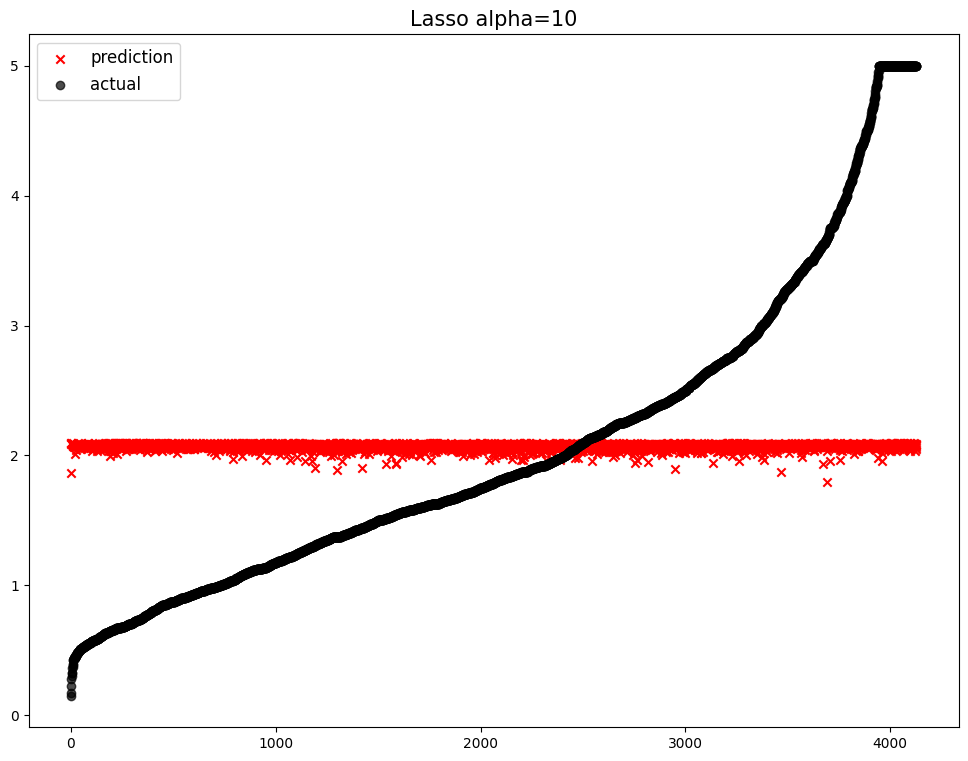

              model       mse
0   Lasso alpha=100  1.310696
1    Lasso alpha=10  1.310227
2  LinearRegression  0.555892


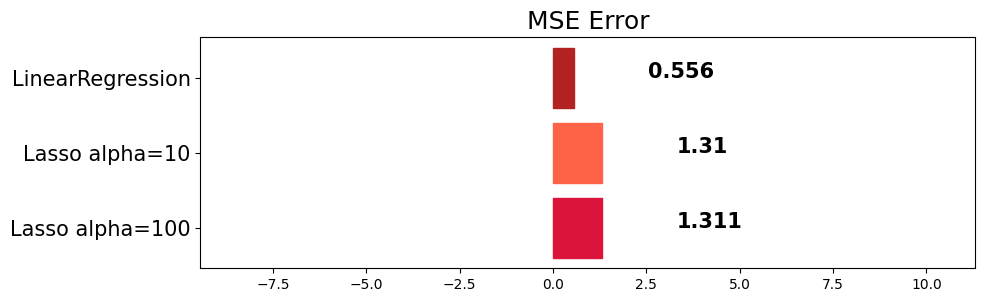

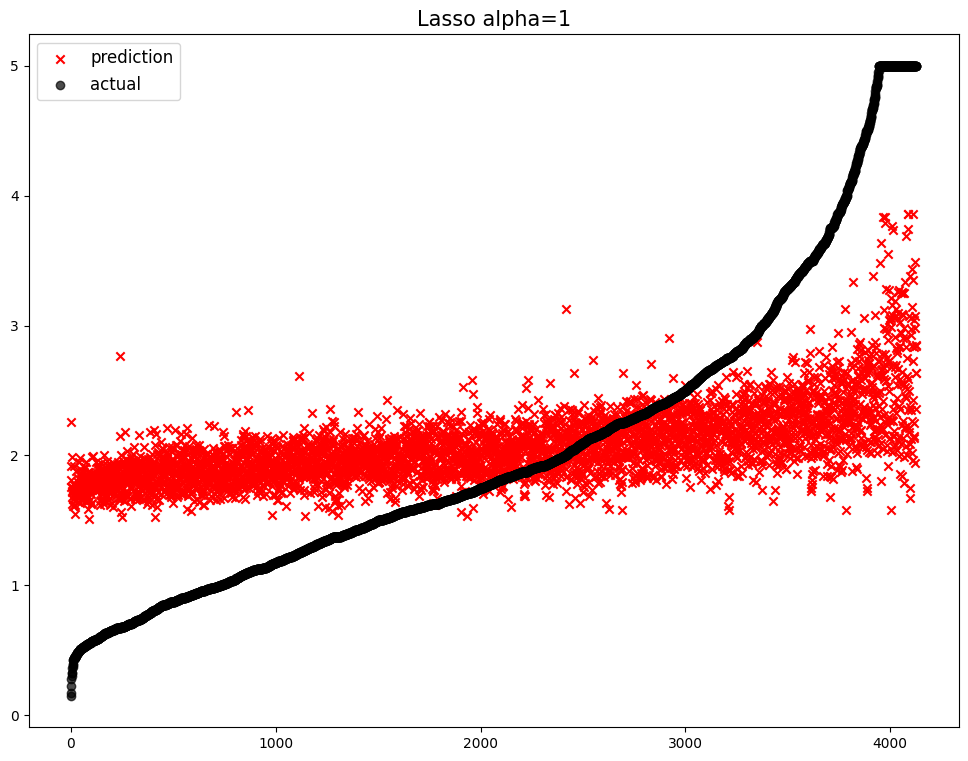

              model       mse
0   Lasso alpha=100  1.310696
1    Lasso alpha=10  1.310227
2     Lasso alpha=1  0.938034
3  LinearRegression  0.555892


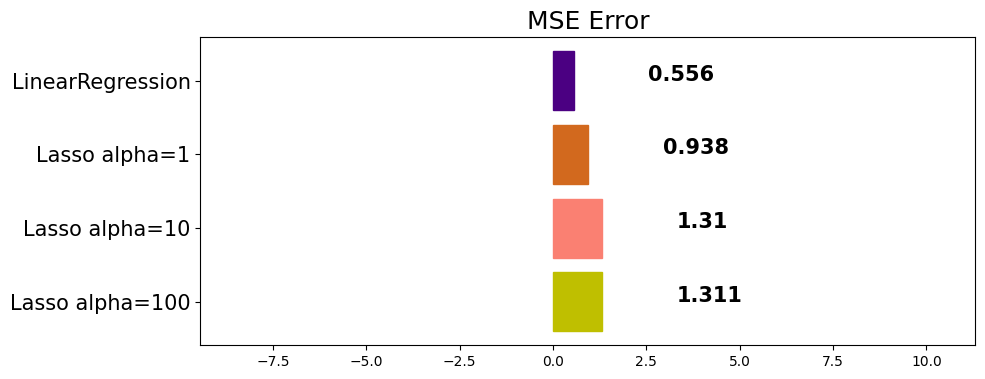

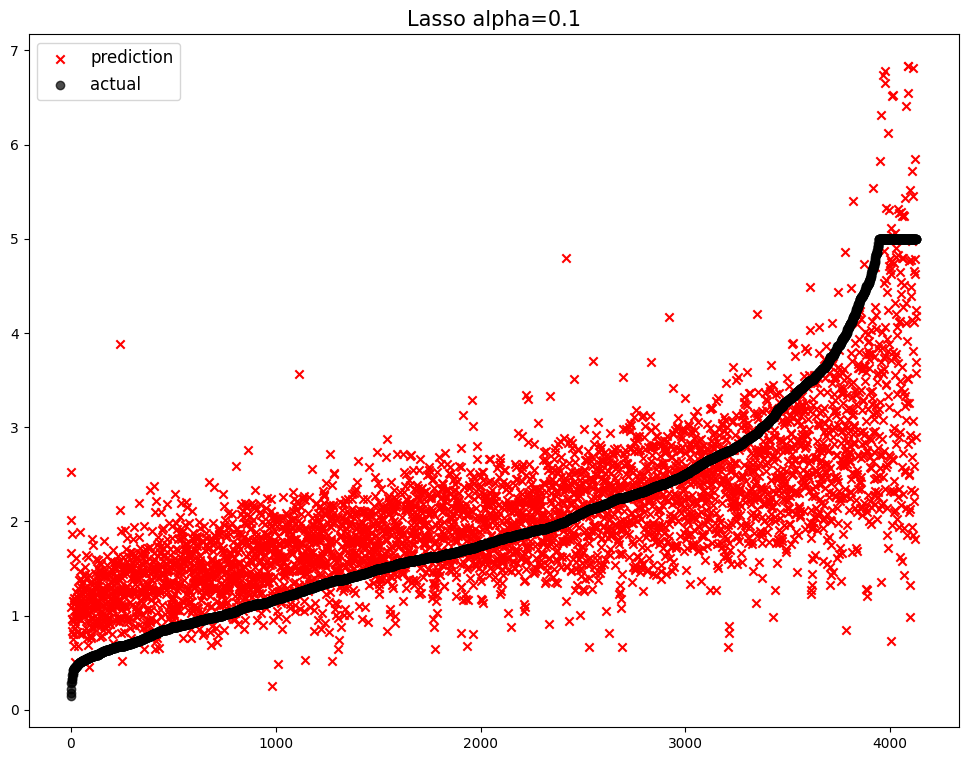

              model       mse
0   Lasso alpha=100  1.310696
1    Lasso alpha=10  1.310227
2     Lasso alpha=1  0.938034
3   Lasso alpha=0.1  0.613512
4  LinearRegression  0.555892


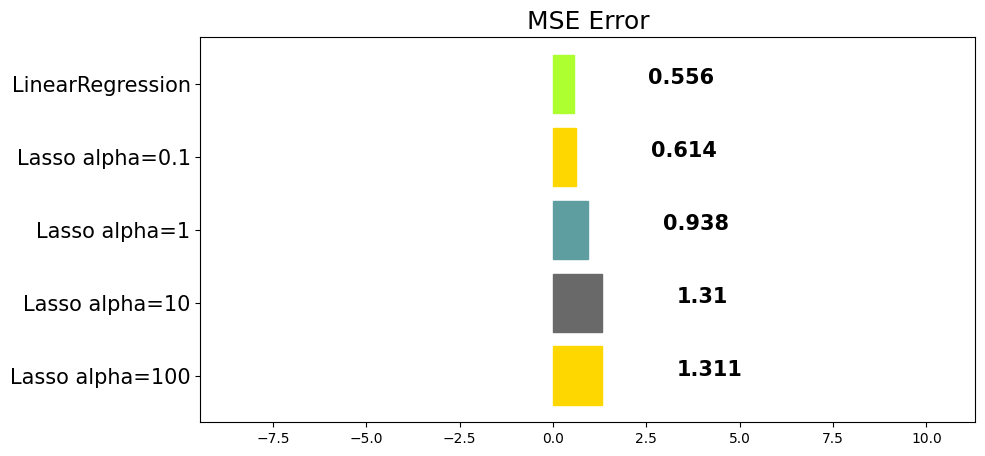

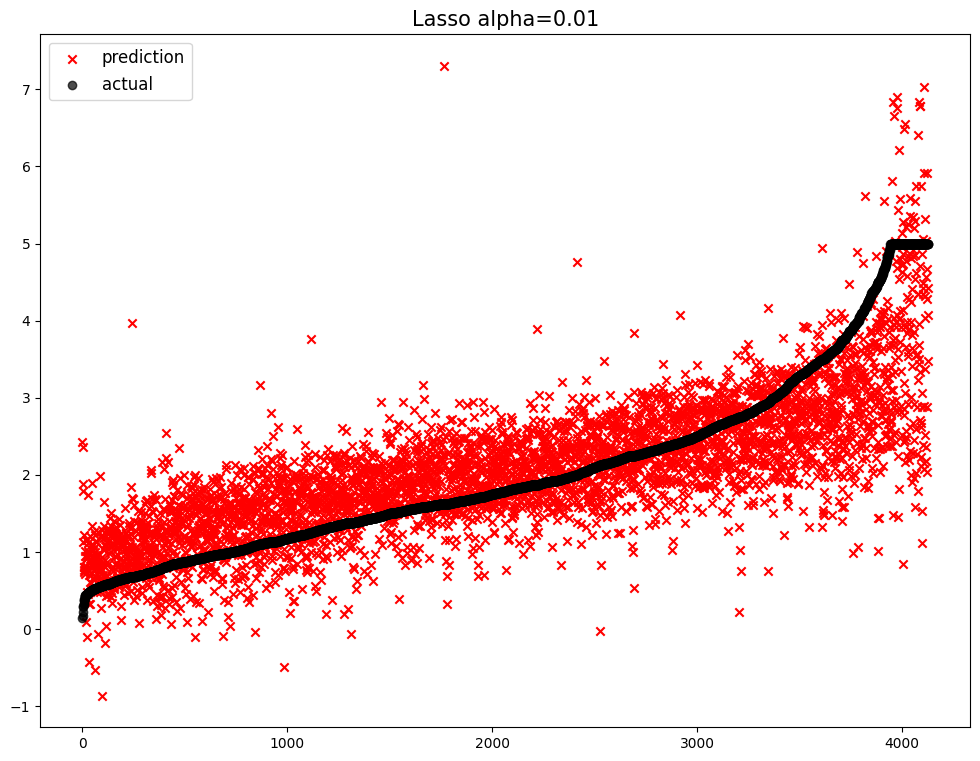

              model       mse
0   Lasso alpha=100  1.310696
1    Lasso alpha=10  1.310227
2     Lasso alpha=1  0.938034
3   Lasso alpha=0.1  0.613512
4  LinearRegression  0.555892
5  Lasso alpha=0.01  0.544449


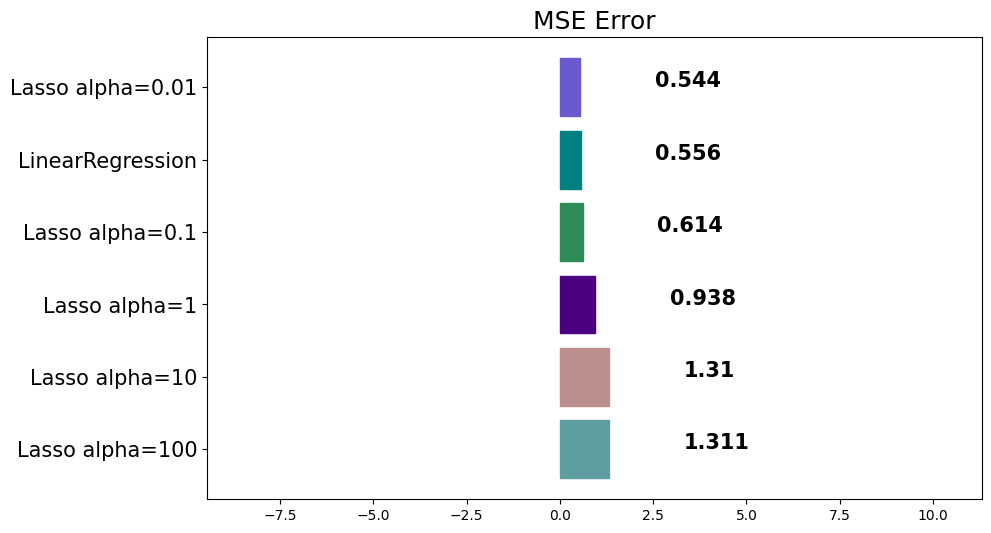

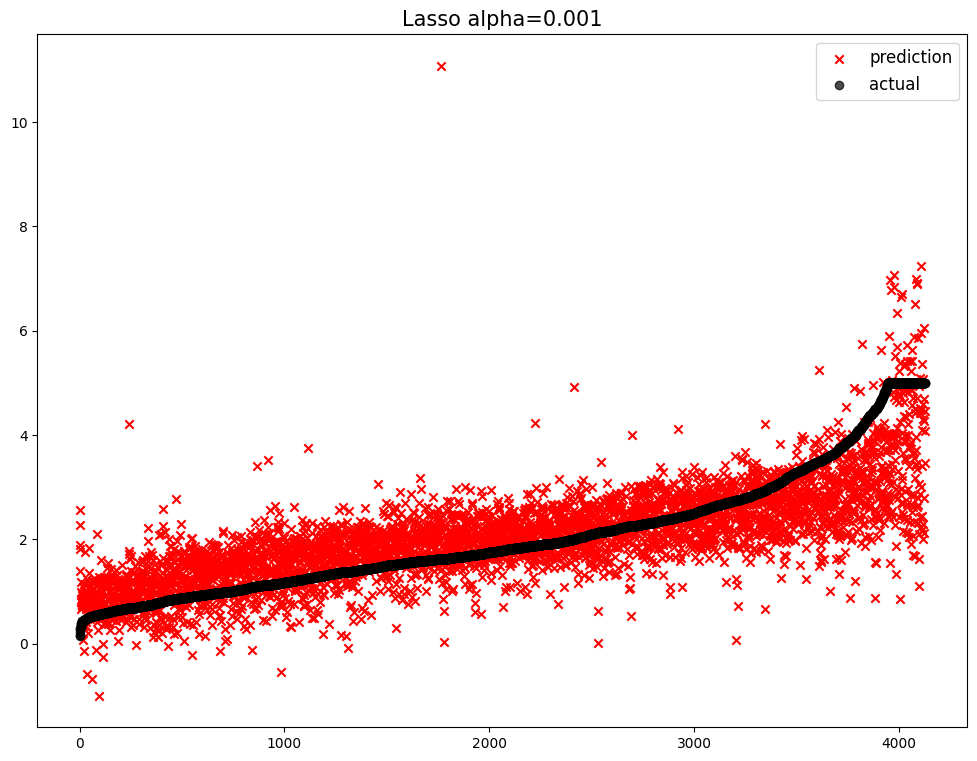

               model       mse
0    Lasso alpha=100  1.310696
1     Lasso alpha=10  1.310227
2      Lasso alpha=1  0.938034
3    Lasso alpha=0.1  0.613512
4   LinearRegression  0.555892
5  Lasso alpha=0.001  0.553894
6   Lasso alpha=0.01  0.544449


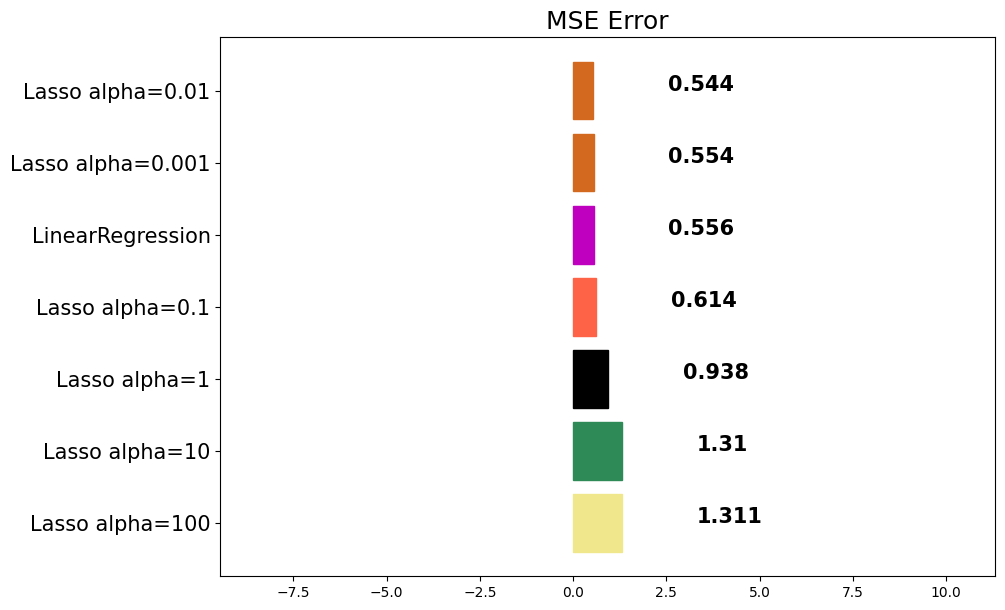

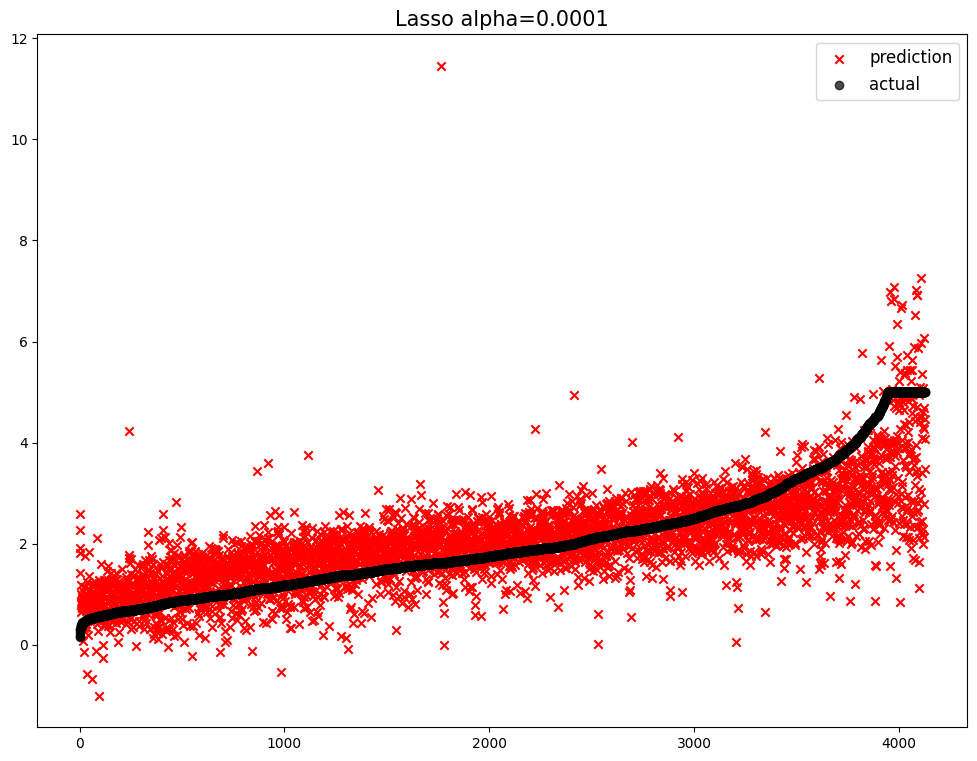

                model       mse
0     Lasso alpha=100  1.310696
1      Lasso alpha=10  1.310227
2       Lasso alpha=1  0.938034
3     Lasso alpha=0.1  0.613512
4    LinearRegression  0.555892
5  Lasso alpha=0.0001  0.555683
6   Lasso alpha=0.001  0.553894
7    Lasso alpha=0.01  0.544449


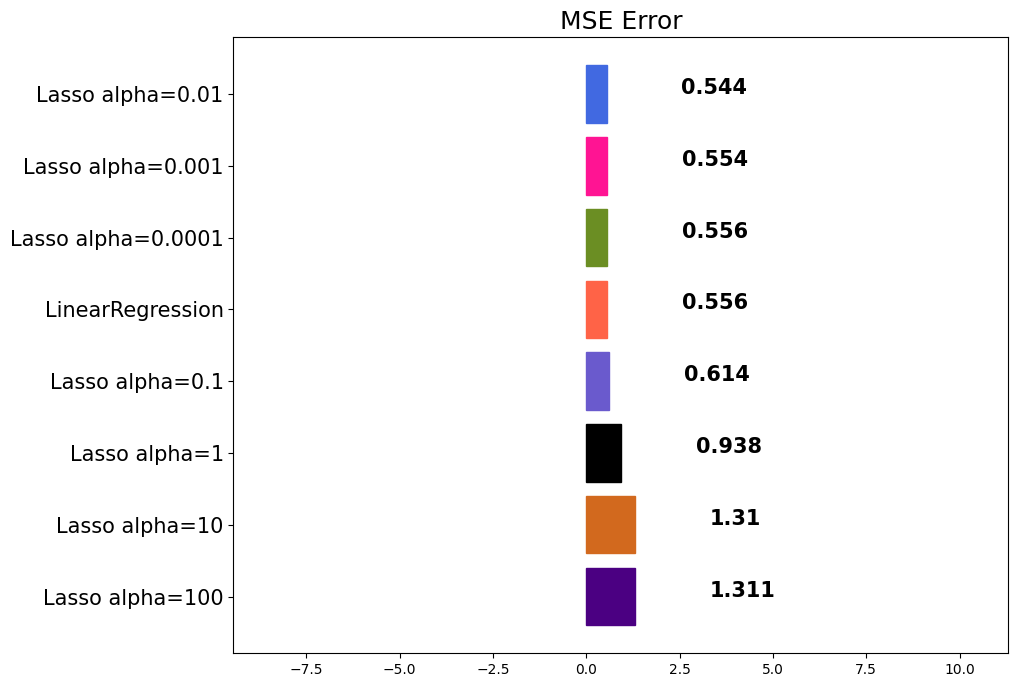

In [15]:
# Lasso Regression : L1 penalty
# Ridge Regression : L2 penalty
from sklearn.linear_model import Ridge, Lasso

alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]

for alpha in alphas:
    # 1. 모델 생성
    model = Lasso(alpha=alpha)
    # 2. 모델 학습
    model.fit(data_train, target_train)
    # 3. 모델 예측
    y_pred = model.predict(data_test)
    # 4. 모델 평가
    mse = mean_squared_error(target_test, y_pred)
    mse_eval(f'Lasso alpha={alpha}', y_pred, target_test)

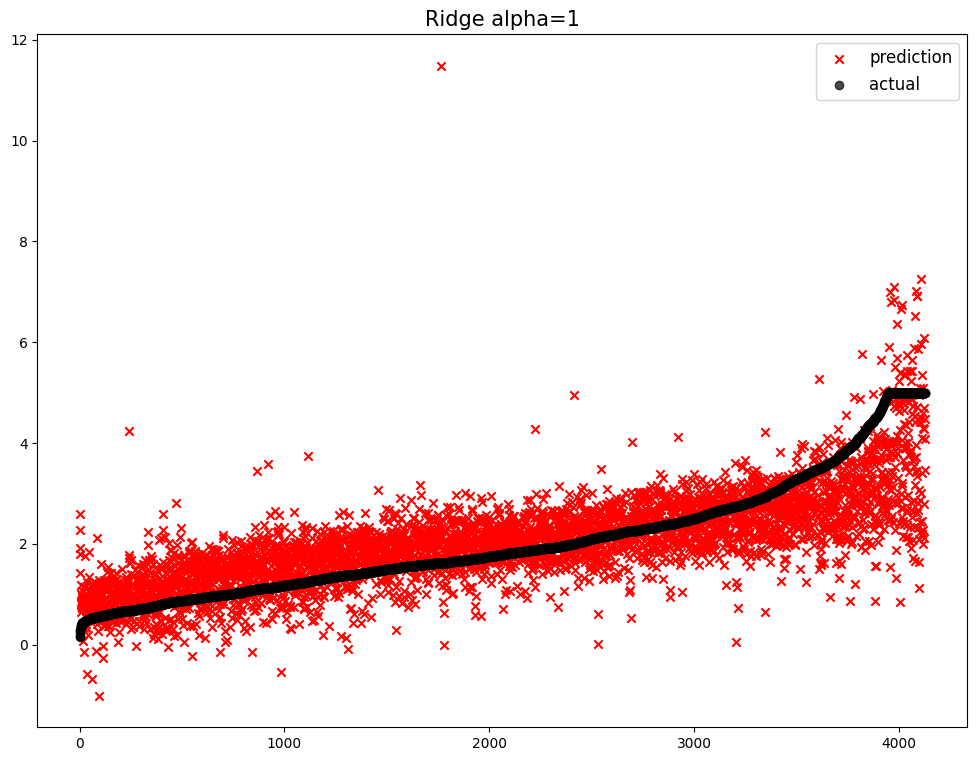

                model       mse
0     Lasso alpha=100  1.310696
1      Lasso alpha=10  1.310227
2       Lasso alpha=1  0.938034
3     Lasso alpha=0.1  0.613512
4    LinearRegression  0.555892
5       Ridge alpha=1  0.555803
6  Lasso alpha=0.0001  0.555683
7   Lasso alpha=0.001  0.553894
8    Lasso alpha=0.01  0.544449


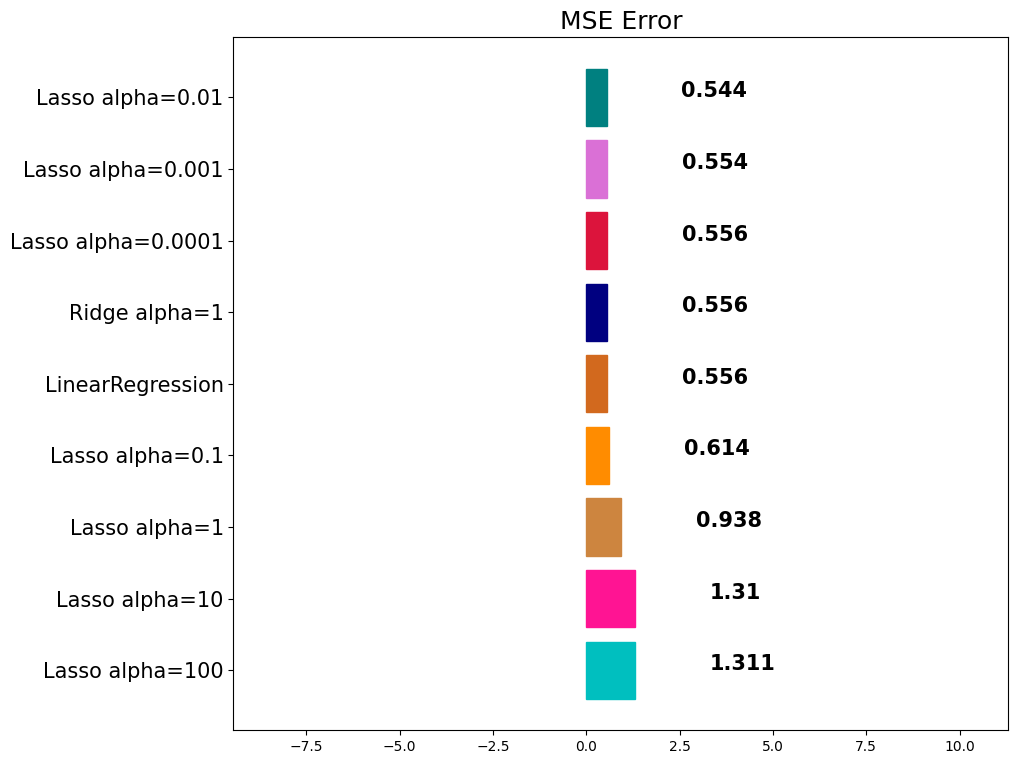

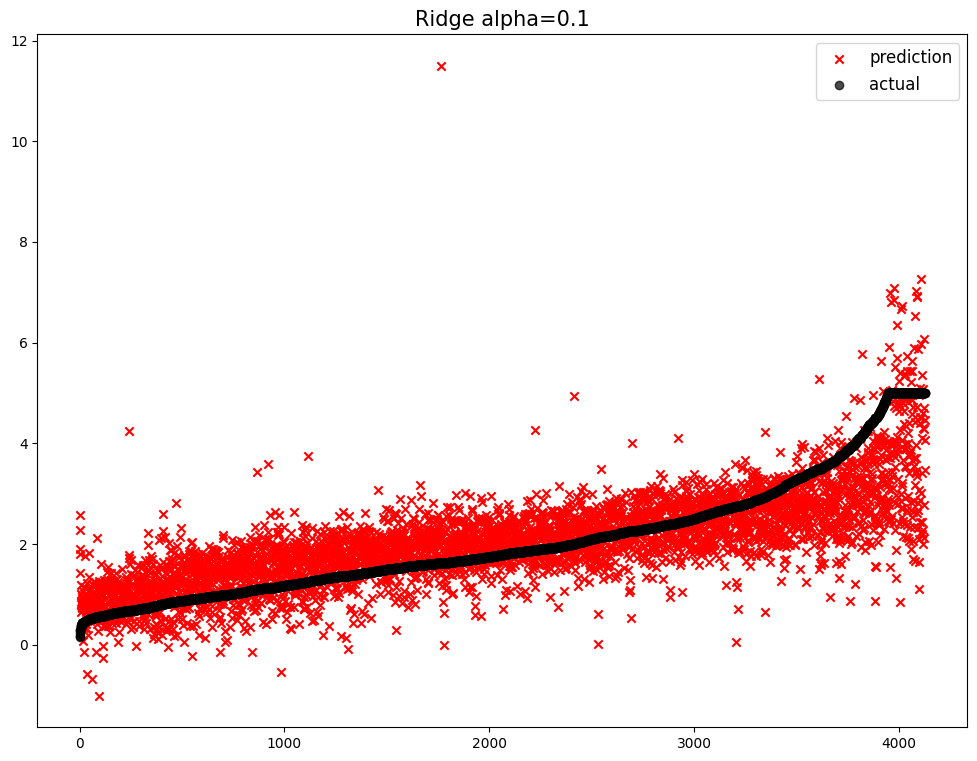

                model       mse
0     Lasso alpha=100  1.310696
1      Lasso alpha=10  1.310227
2       Lasso alpha=1  0.938034
3     Lasso alpha=0.1  0.613512
4    LinearRegression  0.555892
5     Ridge alpha=0.1  0.555883
6       Ridge alpha=1  0.555803
7  Lasso alpha=0.0001  0.555683
8   Lasso alpha=0.001  0.553894
9    Lasso alpha=0.01  0.544449


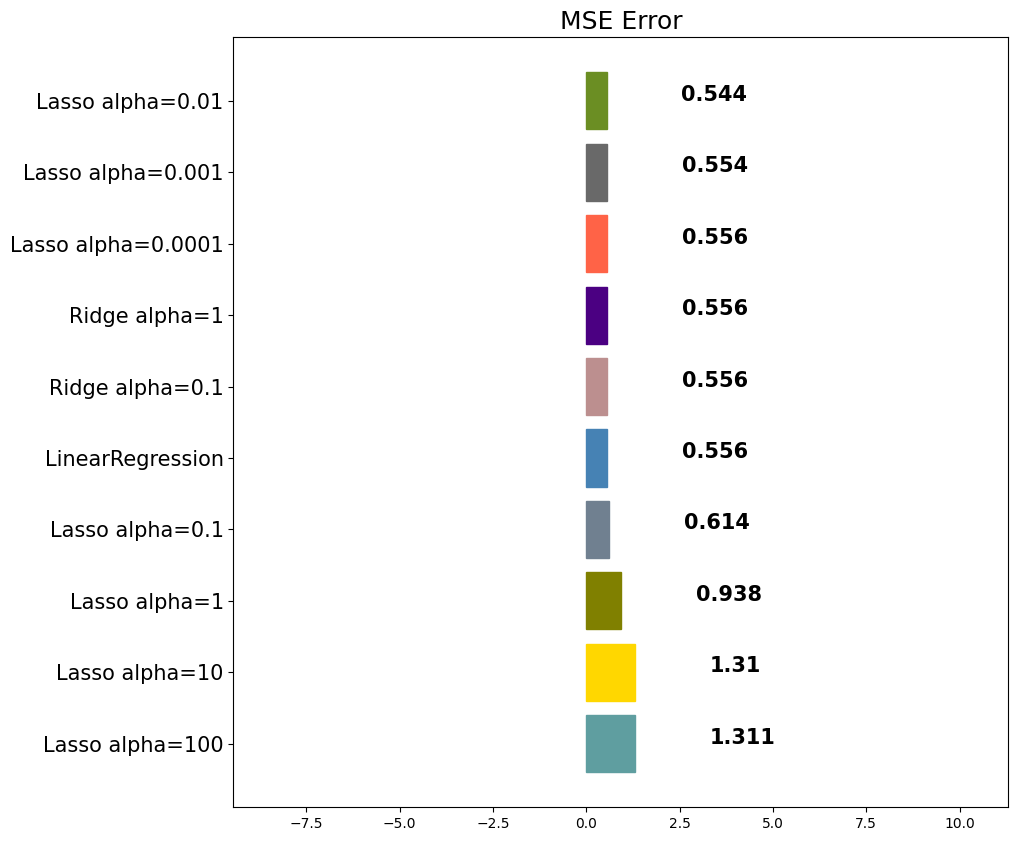

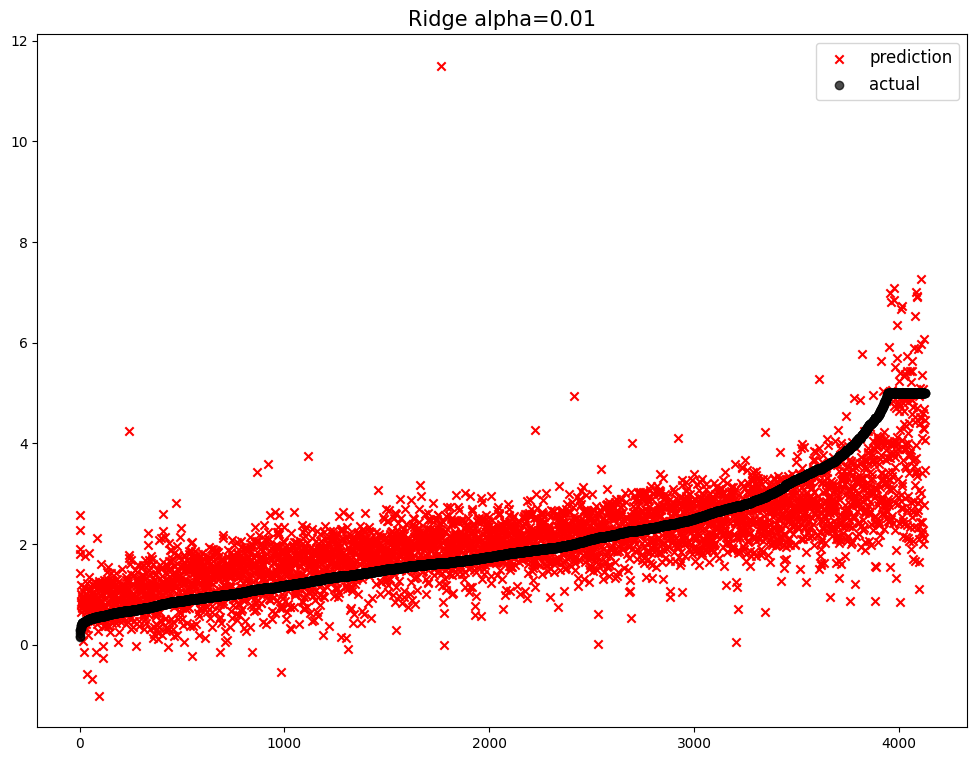

                 model       mse
0      Lasso alpha=100  1.310696
1       Lasso alpha=10  1.310227
2        Lasso alpha=1  0.938034
3      Lasso alpha=0.1  0.613512
4     LinearRegression  0.555892
5     Ridge alpha=0.01  0.555891
6      Ridge alpha=0.1  0.555883
7        Ridge alpha=1  0.555803
8   Lasso alpha=0.0001  0.555683
9    Lasso alpha=0.001  0.553894
10    Lasso alpha=0.01  0.544449


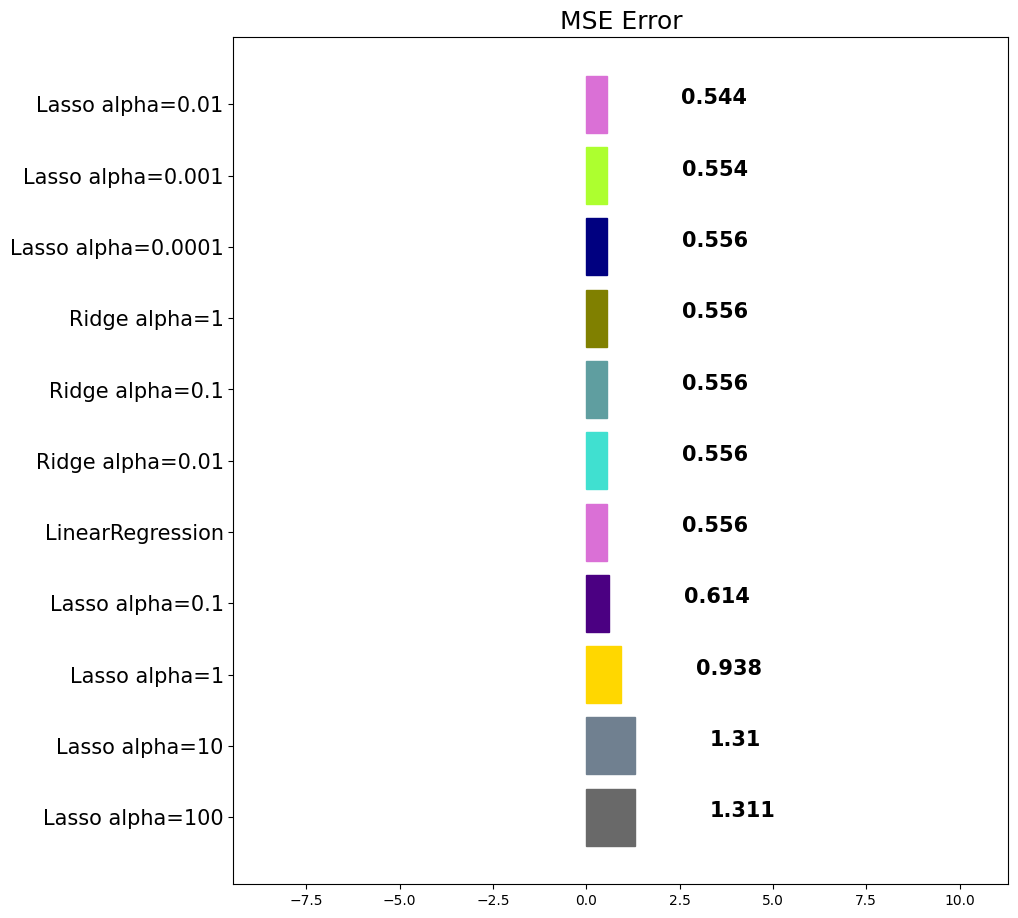

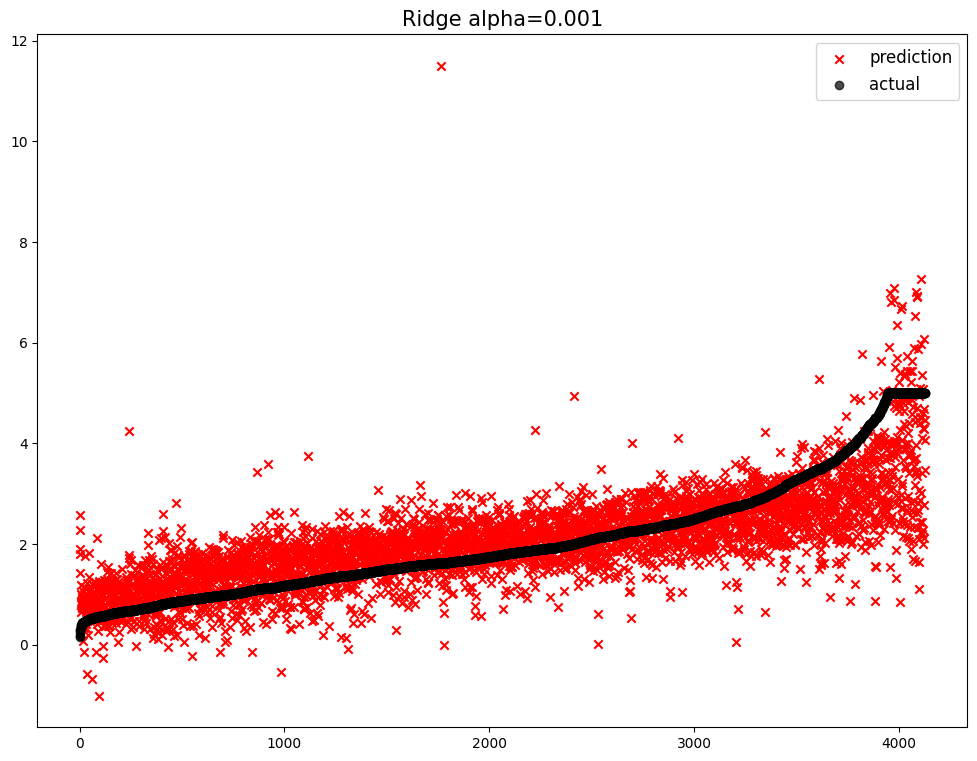

                 model       mse
0      Lasso alpha=100  1.310696
1       Lasso alpha=10  1.310227
2        Lasso alpha=1  0.938034
3      Lasso alpha=0.1  0.613512
4     LinearRegression  0.555892
5    Ridge alpha=0.001  0.555892
6     Ridge alpha=0.01  0.555891
7      Ridge alpha=0.1  0.555883
8        Ridge alpha=1  0.555803
9   Lasso alpha=0.0001  0.555683
10   Lasso alpha=0.001  0.553894
11    Lasso alpha=0.01  0.544449


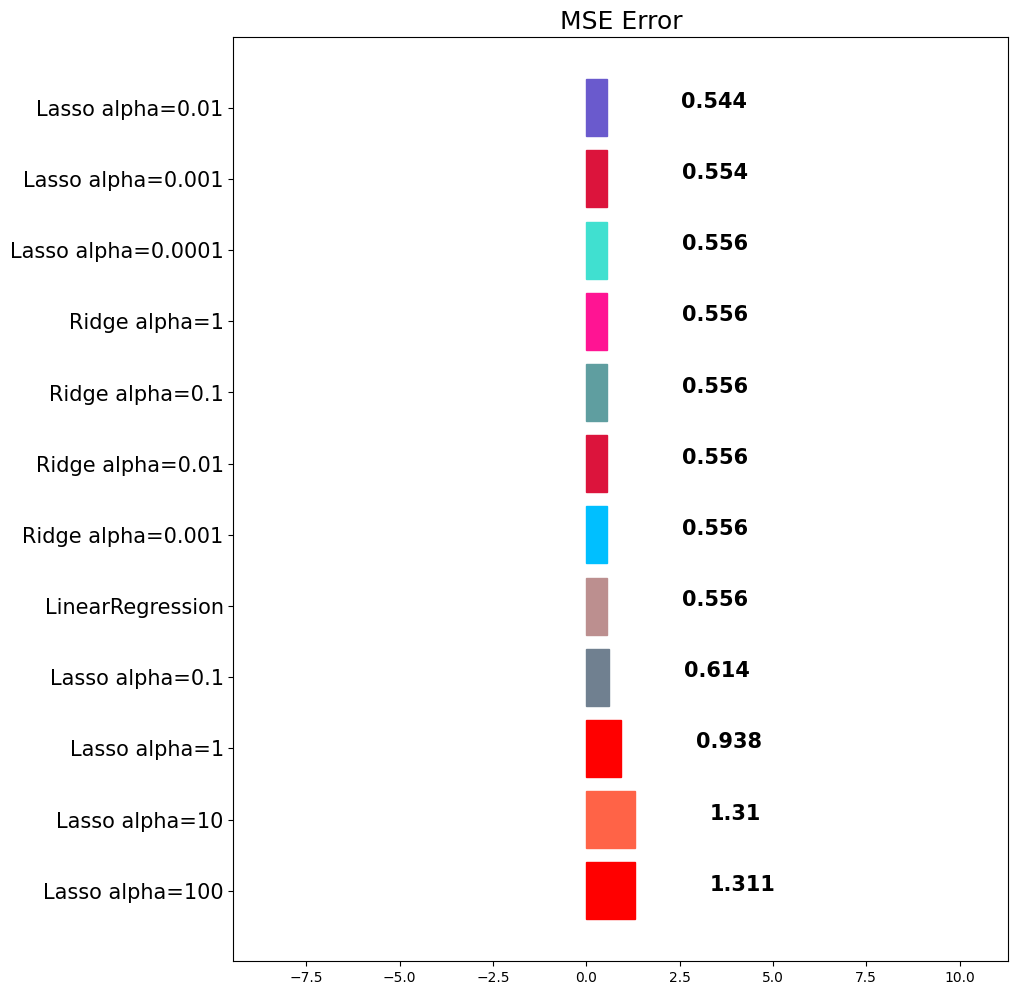

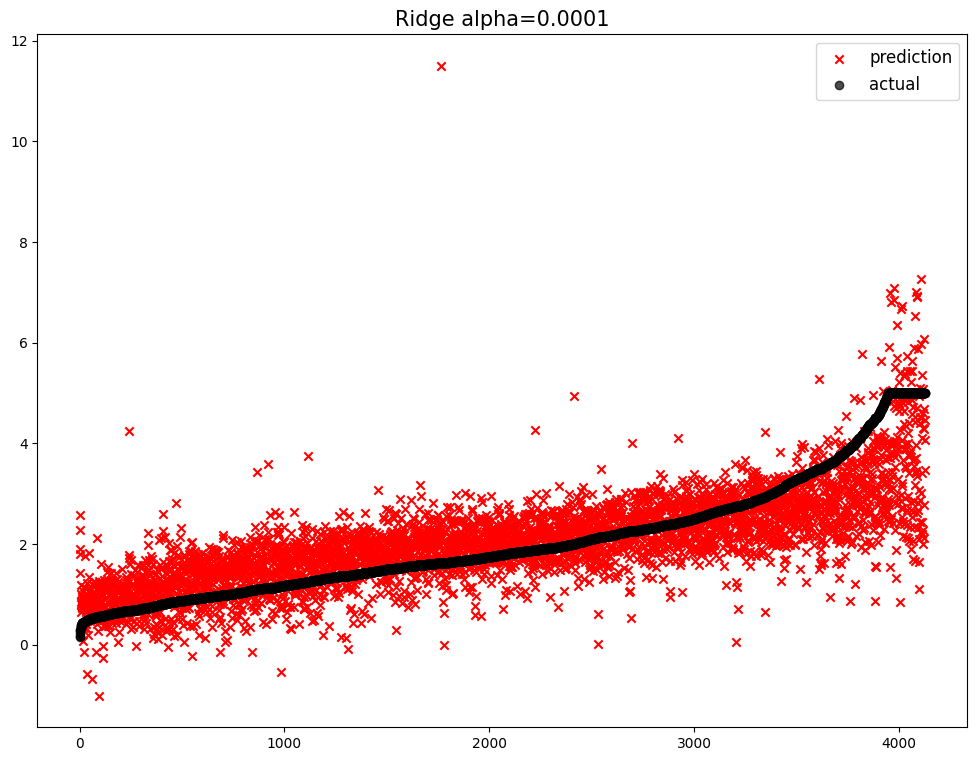

                 model       mse
0      Lasso alpha=100  1.310696
1       Lasso alpha=10  1.310227
2        Lasso alpha=1  0.938034
3      Lasso alpha=0.1  0.613512
4     LinearRegression  0.555892
5   Ridge alpha=0.0001  0.555892
6    Ridge alpha=0.001  0.555892
7     Ridge alpha=0.01  0.555891
8      Ridge alpha=0.1  0.555883
9        Ridge alpha=1  0.555803
10  Lasso alpha=0.0001  0.555683
11   Lasso alpha=0.001  0.553894
12    Lasso alpha=0.01  0.544449


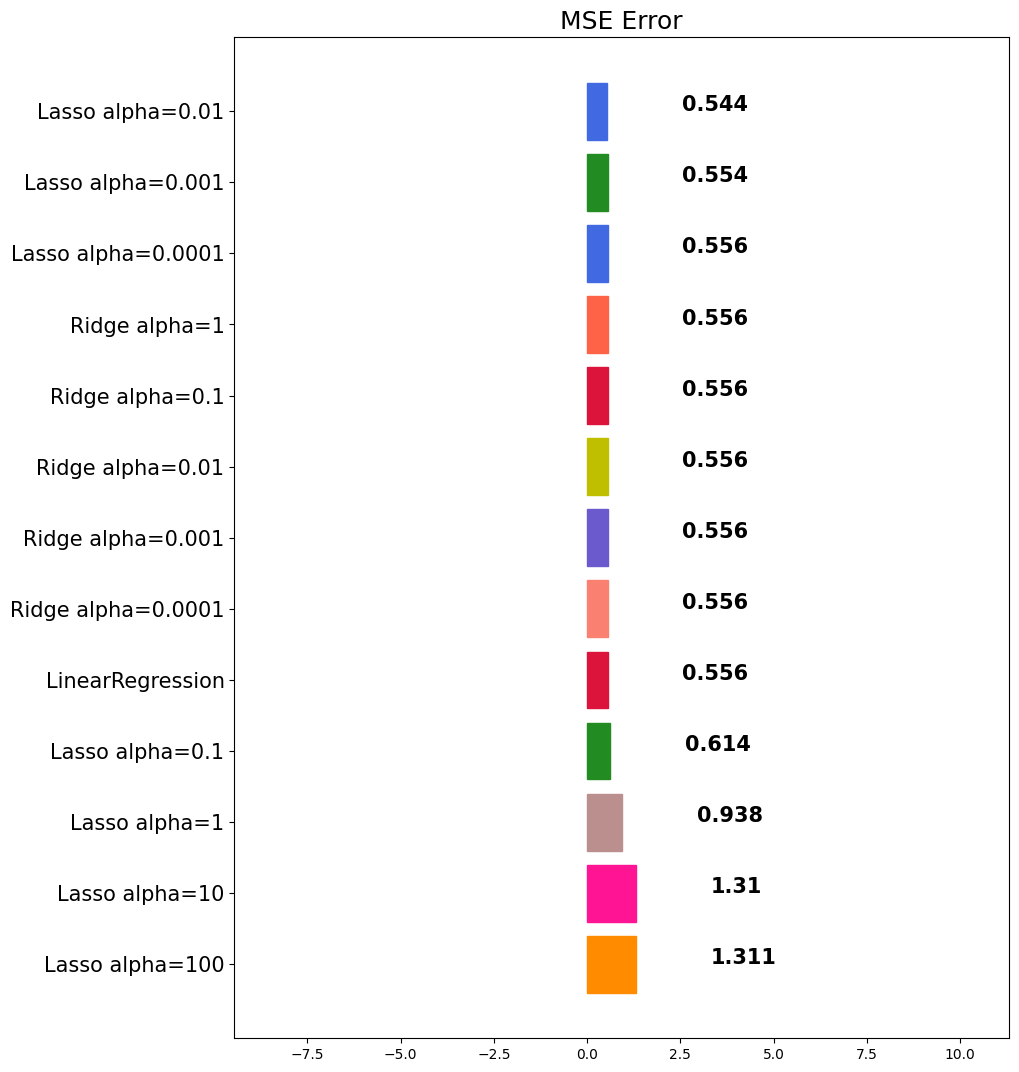

In [16]:
alphas = [1, 0.1, 0.01, 0.001, 0.0001]

for alpha in alphas:
    # 1. 모델 생성
    model = Ridge(alpha=alpha)
    # 2. 모델 학습
    model.fit(data_train, target_train)
    # 3. 모델 예측
    y_pred = model.predict(data_test)
    # 4. 모델 평가
    mse = mean_squared_error(target_test, y_pred)
    mse_eval(f'Ridge alpha={alpha}', y_pred, target_test)

In [17]:
# coef를 시각화하는 함수
def plot_coef(columns, coef):
    coef_df = pd.DataFrame(list(zip(columns, coef)))
    coef_df.columns=['feature', 'coef']
    coef_df = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.barh(np.arange(len(coef_df)), coef_df['coef'])
    idx = np.arange(len(coef_df))
    ax.set_yticks(idx)
    ax.set_yticklabels(coef_df['feature'])
    fig.tight_layout()
    plt.show()

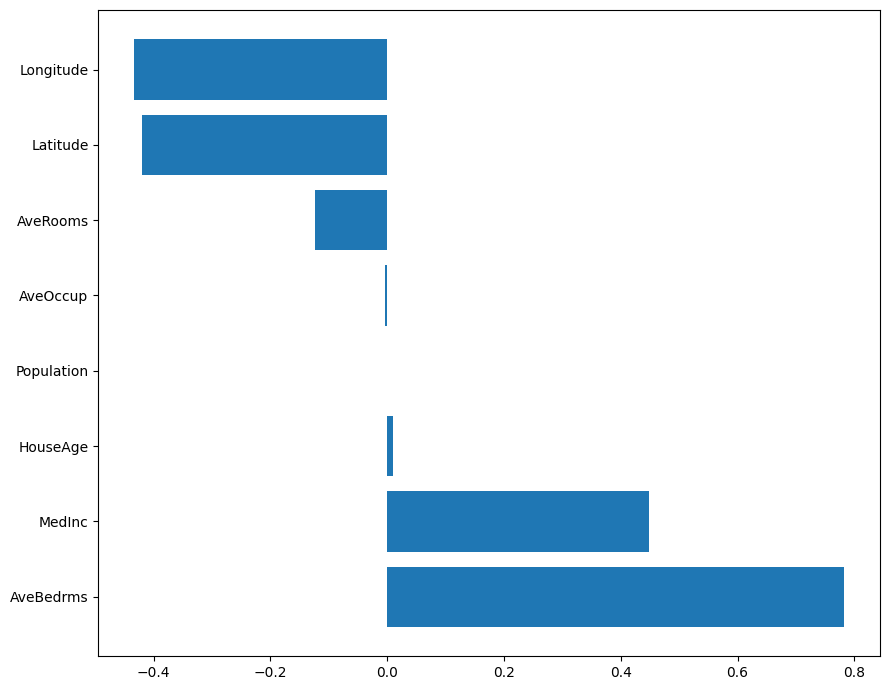

In [18]:
plot_coef(data_test.columns, model.coef_)

In [19]:
# data_train, data_test, target_train, target_test


lasso_1 = Lasso(alpha=1)
lasso_1.fit(data_train, target_train)
lasso_pred_1 = lasso_1.predict(data_test)

lasso_001 = Lasso(alpha=0.001)
lasso_001.fit(data_train, target_train)
lasso_pred_001 = lasso_001.predict(data_test)

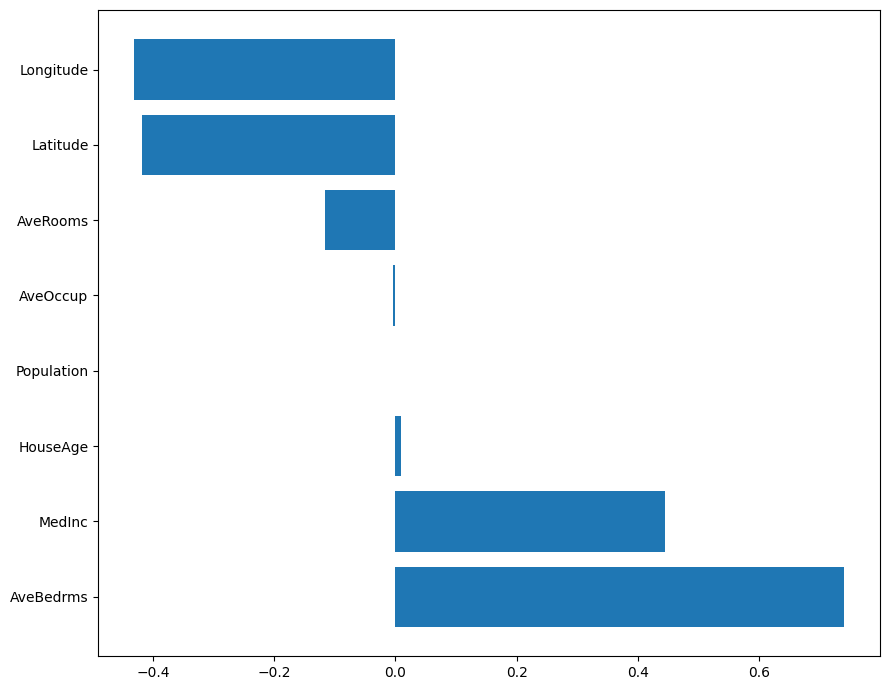

In [20]:
plot_coef(data_train.columns, lasso_001.coef_)

### Lasso + Ridge -> ElasticNet

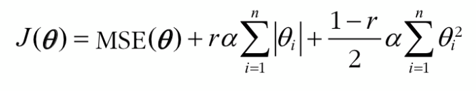

**l1_ratio (default=0.5)**

 * l1_ratio = 0 (L2 규제만 사용). 
 * l1_ratio = 1 (L1 규제만 사용). 
 * 0 < l1_ratio < 1 (L1 and L2 규제의 혼합사용)

In [21]:
# # data_train, data_test, target_train, target_test

from sklearn.linear_model import ElasticNet

ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

#l1_ratio의 값이 클때(L1의 비중을 크게 설정할때) 성능이 떨어질 수 있다.
for ratio in ratios:
    model = ElasticNet(alpha=0.5, l1_ratio=ratio, random_state=42)
    model.fit(data_train, target_train)
    y_pred = model.predict(data_test)
    print(f"Ratio: {ratio}, RMSE: {np.sqrt(mean_squared_error(target_test, y_pred))}")


Ratio: 0.1, RMSE: 0.7852243120786745
Ratio: 0.3, RMSE: 0.8187332850874025
Ratio: 0.5, RMSE: 0.8287780633584366
Ratio: 0.7, RMSE: 0.8366982880877543
Ratio: 0.9, RMSE: 0.846577317743052


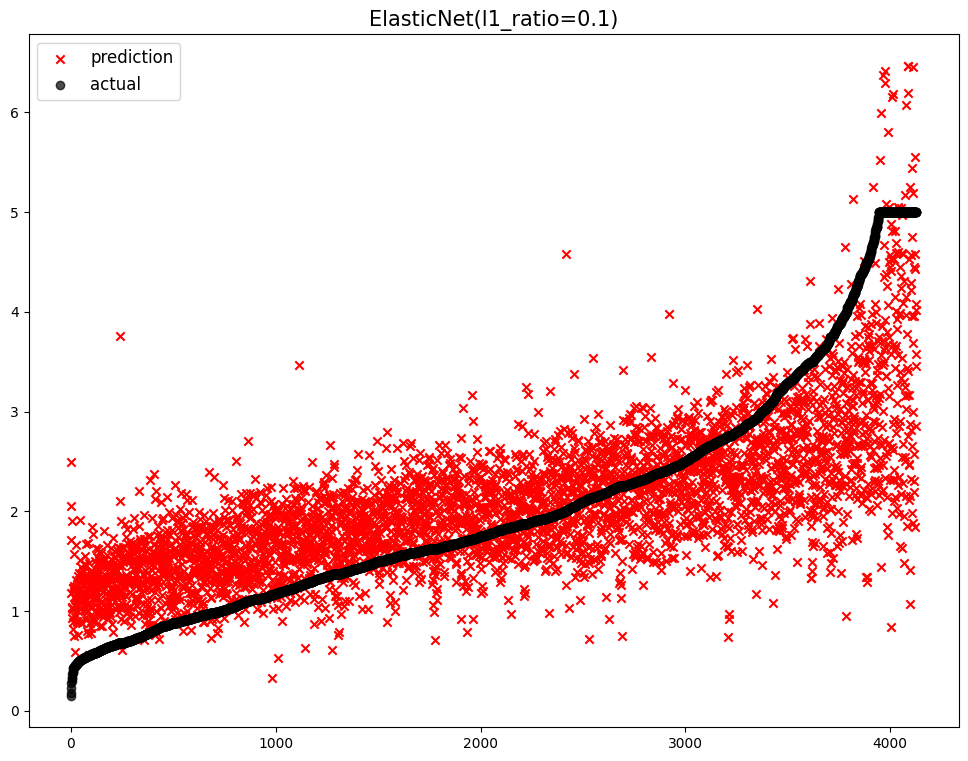

                       model       mse
0            Lasso alpha=100  1.310696
1             Lasso alpha=10  1.310227
2              Lasso alpha=1  0.938034
3   ElasticNet(l1_ratio=0.1)  0.616577
4            Lasso alpha=0.1  0.613512
5           LinearRegression  0.555892
6         Ridge alpha=0.0001  0.555892
7          Ridge alpha=0.001  0.555892
8           Ridge alpha=0.01  0.555891
9            Ridge alpha=0.1  0.555883
10             Ridge alpha=1  0.555803
11        Lasso alpha=0.0001  0.555683
12         Lasso alpha=0.001  0.553894
13          Lasso alpha=0.01  0.544449


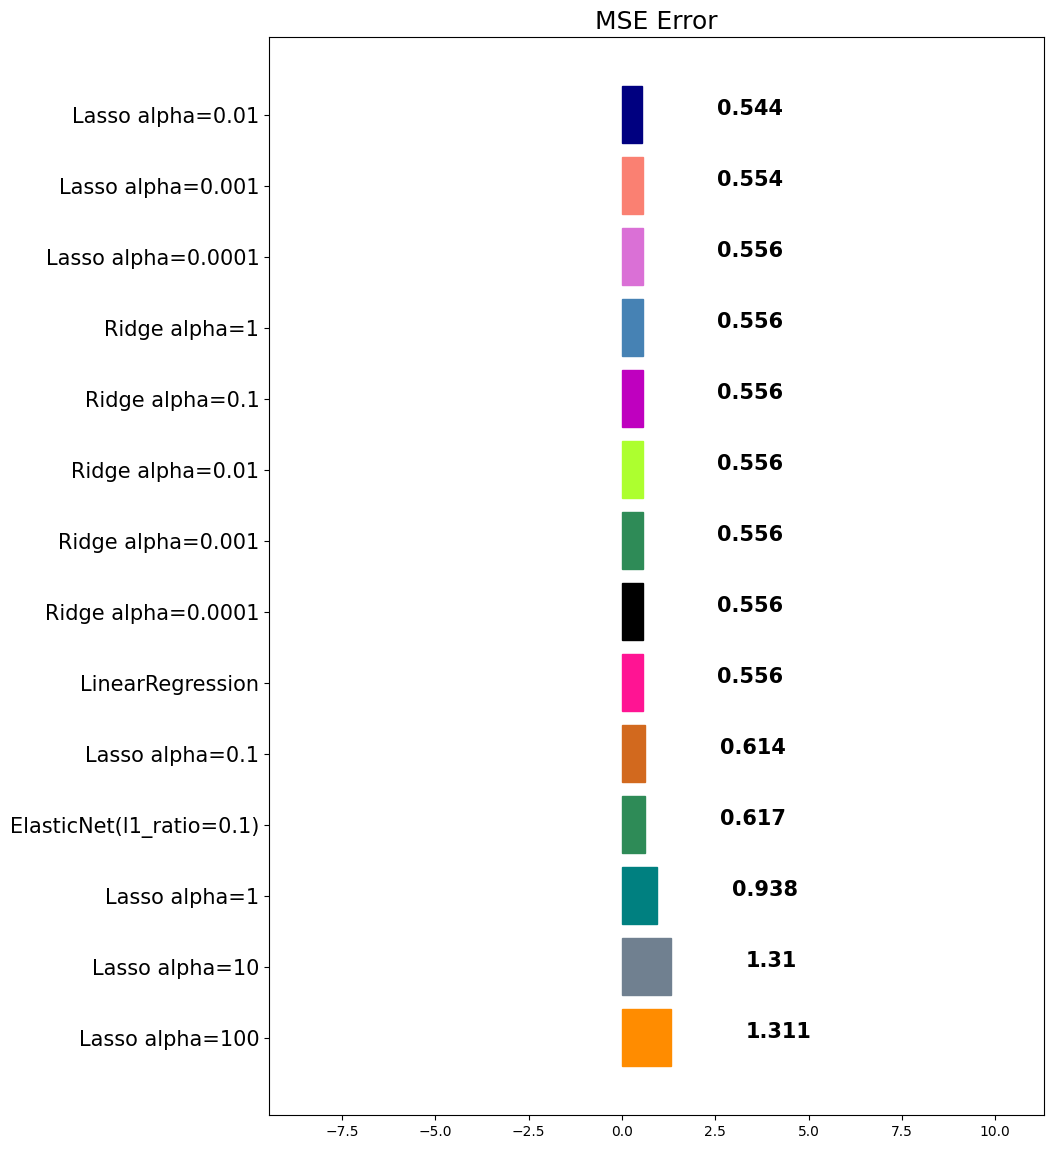

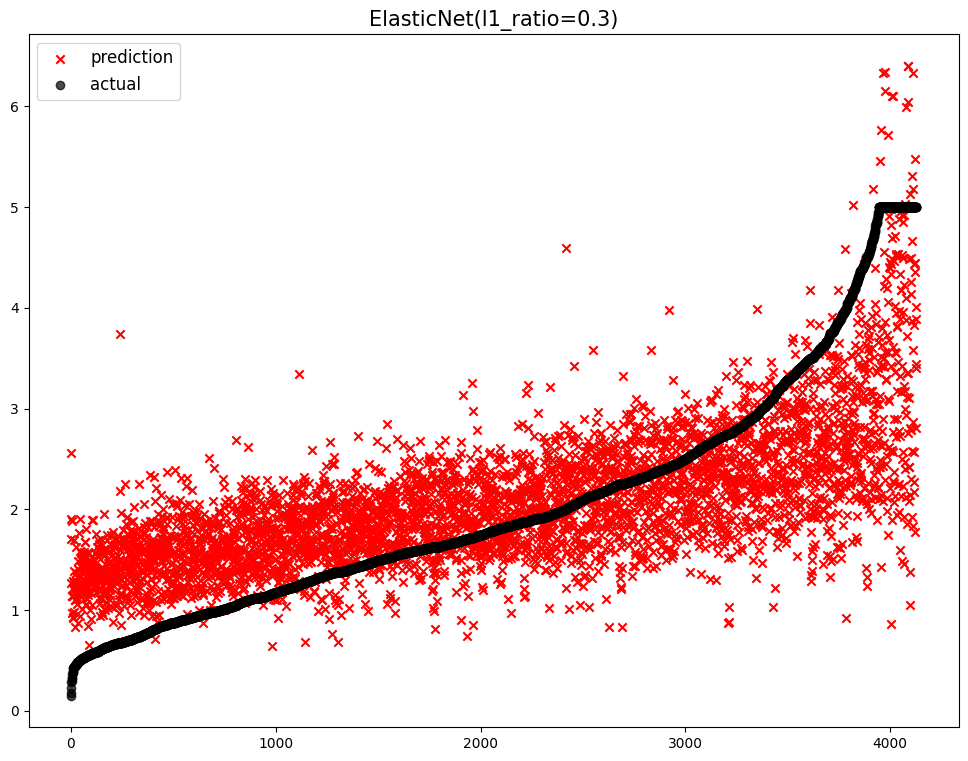

                       model       mse
0            Lasso alpha=100  1.310696
1             Lasso alpha=10  1.310227
2              Lasso alpha=1  0.938034
3   ElasticNet(l1_ratio=0.3)  0.670324
4   ElasticNet(l1_ratio=0.1)  0.616577
5            Lasso alpha=0.1  0.613512
6           LinearRegression  0.555892
7         Ridge alpha=0.0001  0.555892
8          Ridge alpha=0.001  0.555892
9           Ridge alpha=0.01  0.555891
10           Ridge alpha=0.1  0.555883
11             Ridge alpha=1  0.555803
12        Lasso alpha=0.0001  0.555683
13         Lasso alpha=0.001  0.553894
14          Lasso alpha=0.01  0.544449


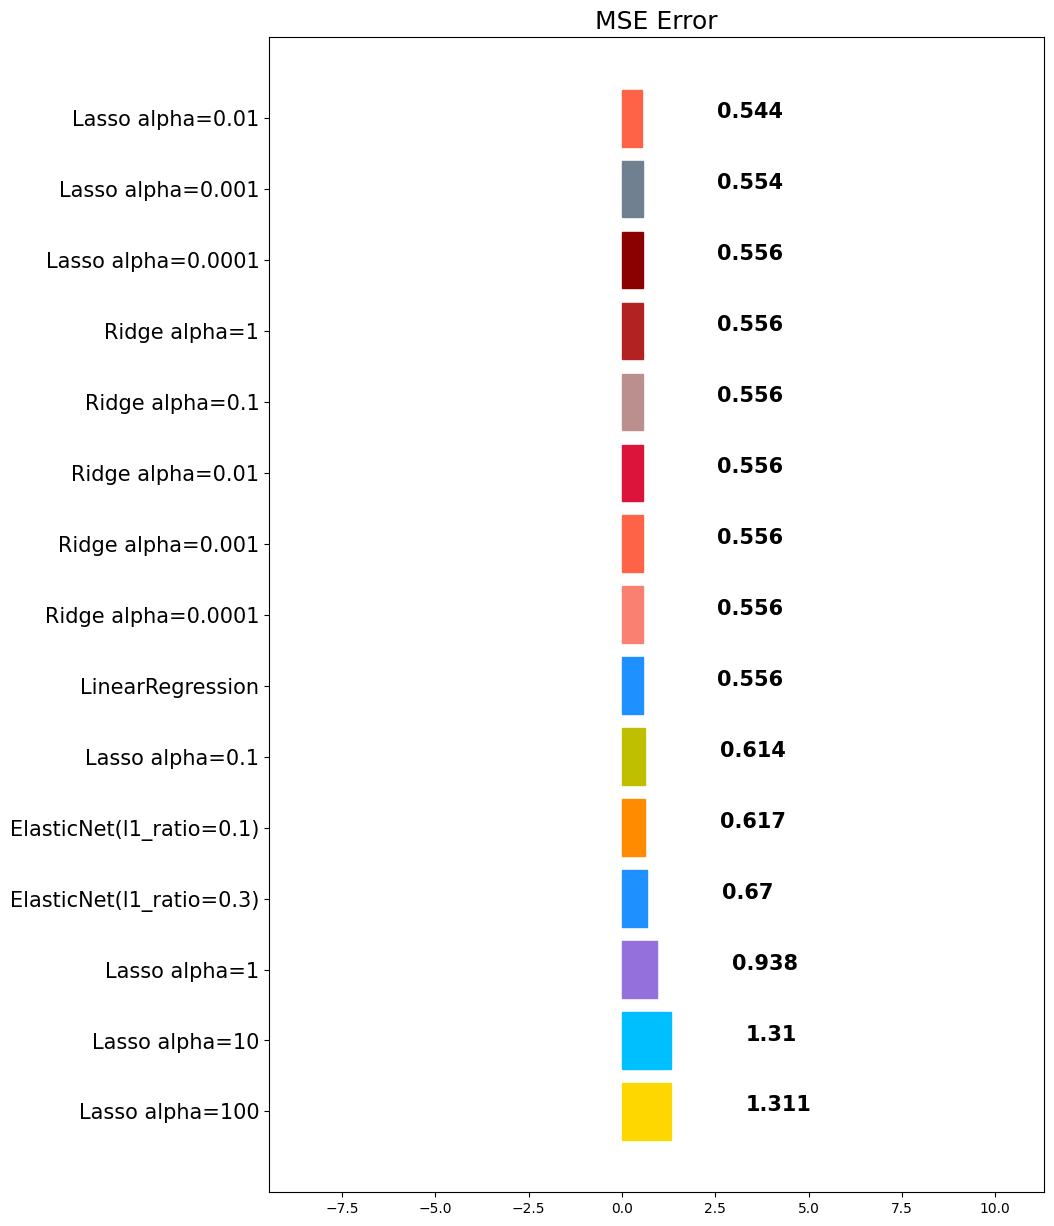

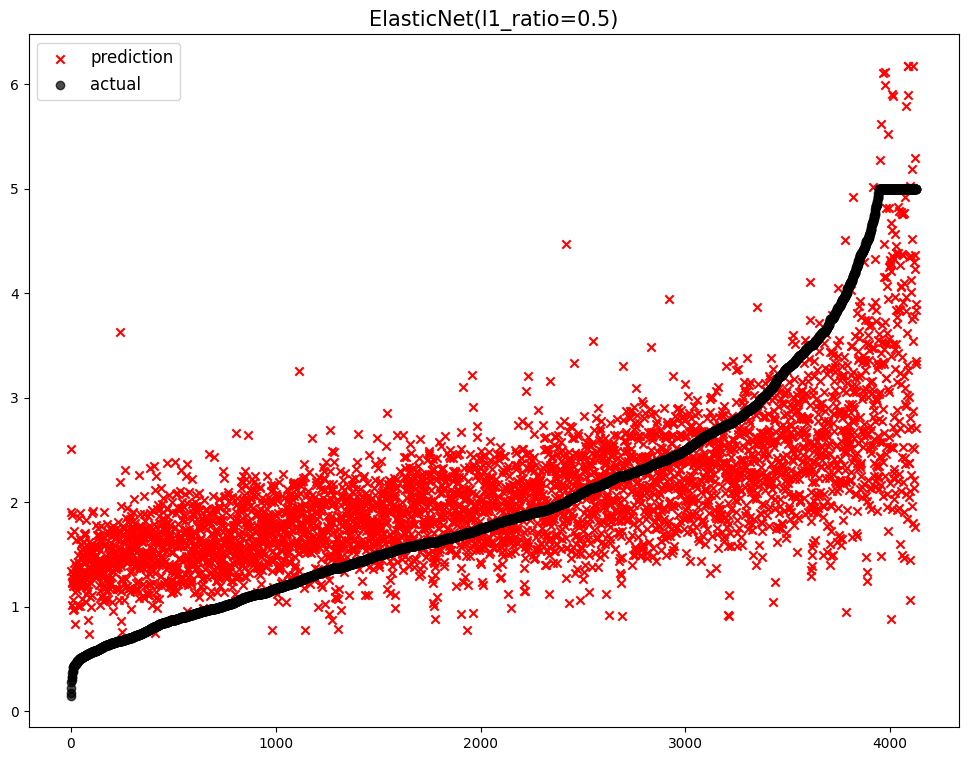

                       model       mse
0            Lasso alpha=100  1.310696
1             Lasso alpha=10  1.310227
2              Lasso alpha=1  0.938034
3   ElasticNet(l1_ratio=0.5)  0.686873
4   ElasticNet(l1_ratio=0.3)  0.670324
5   ElasticNet(l1_ratio=0.1)  0.616577
6            Lasso alpha=0.1  0.613512
7           LinearRegression  0.555892
8         Ridge alpha=0.0001  0.555892
9          Ridge alpha=0.001  0.555892
10          Ridge alpha=0.01  0.555891
11           Ridge alpha=0.1  0.555883
12             Ridge alpha=1  0.555803
13        Lasso alpha=0.0001  0.555683
14         Lasso alpha=0.001  0.553894
15          Lasso alpha=0.01  0.544449


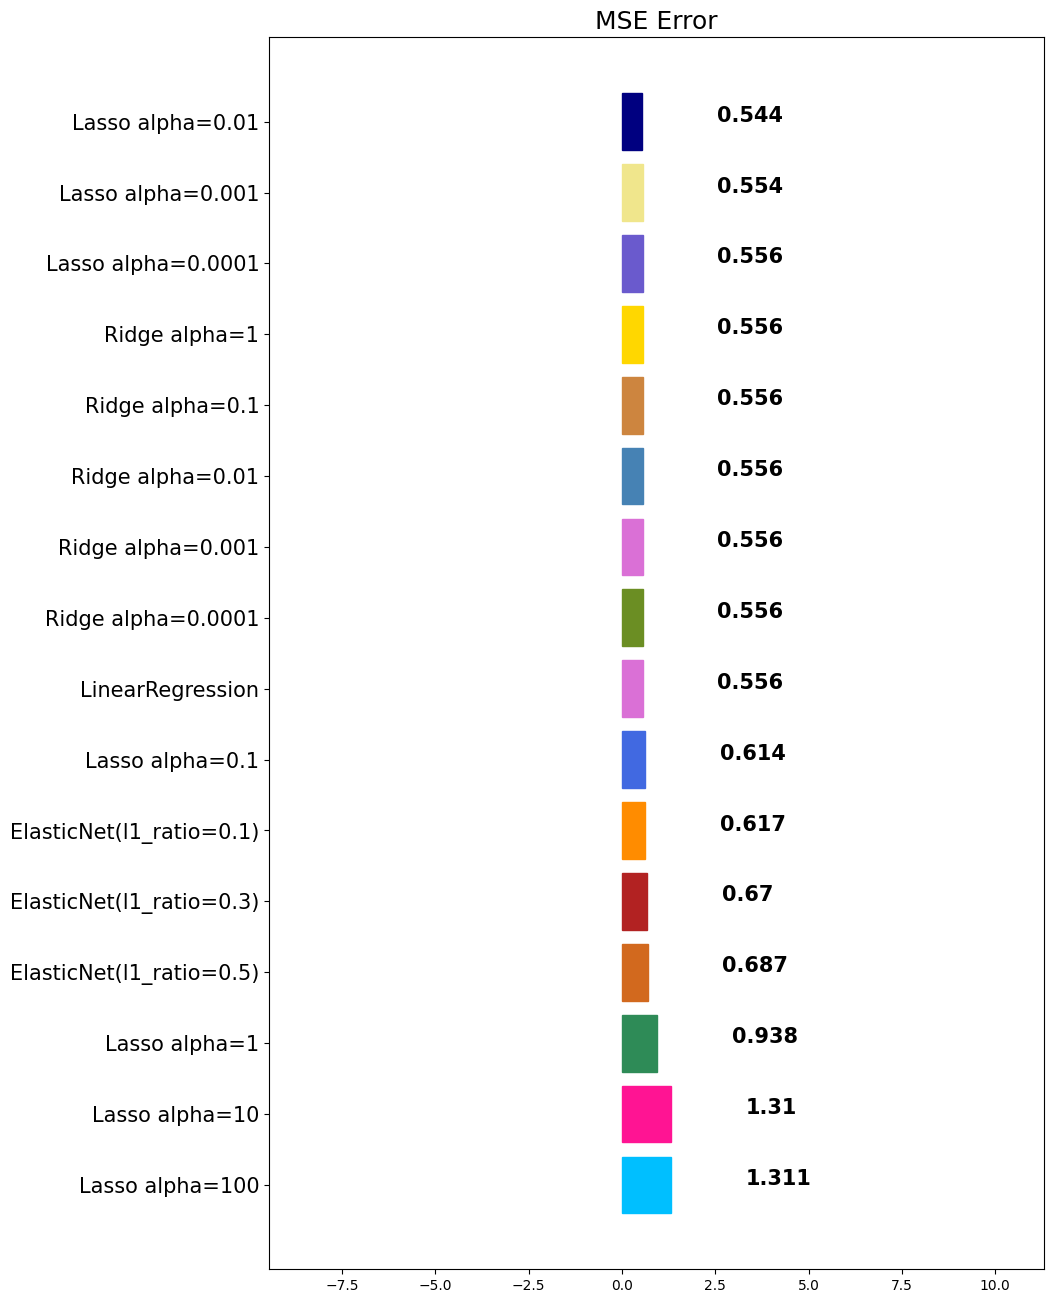

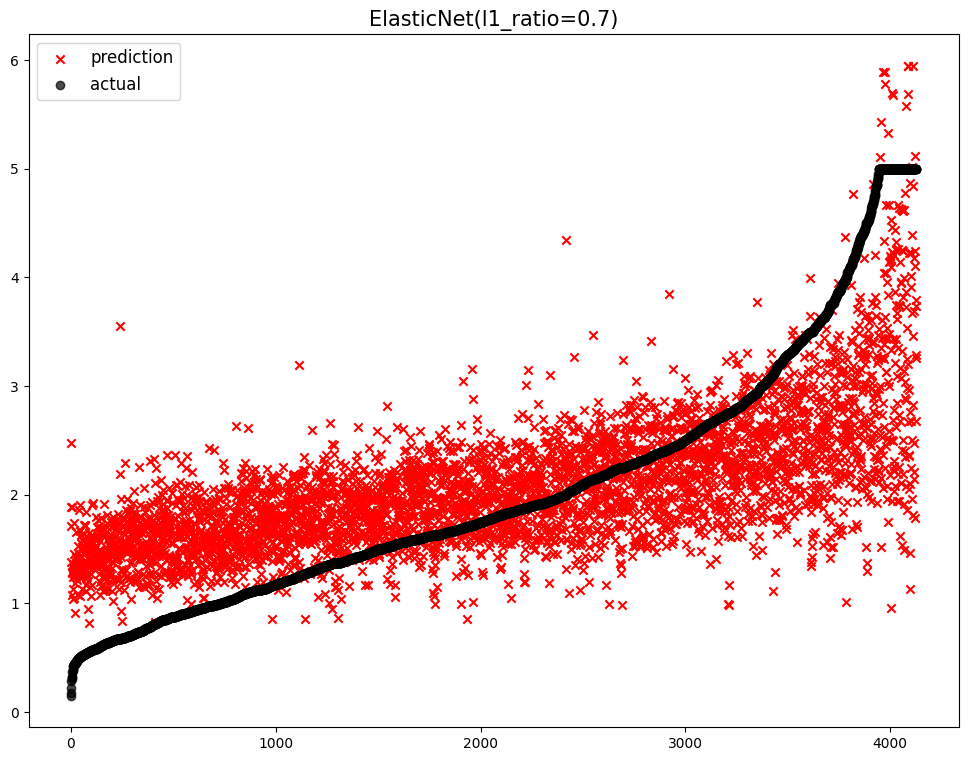

                       model       mse
0            Lasso alpha=100  1.310696
1             Lasso alpha=10  1.310227
2              Lasso alpha=1  0.938034
3   ElasticNet(l1_ratio=0.7)  0.700064
4   ElasticNet(l1_ratio=0.5)  0.686873
5   ElasticNet(l1_ratio=0.3)  0.670324
6   ElasticNet(l1_ratio=0.1)  0.616577
7            Lasso alpha=0.1  0.613512
8           LinearRegression  0.555892
9         Ridge alpha=0.0001  0.555892
10         Ridge alpha=0.001  0.555892
11          Ridge alpha=0.01  0.555891
12           Ridge alpha=0.1  0.555883
13             Ridge alpha=1  0.555803
14        Lasso alpha=0.0001  0.555683
15         Lasso alpha=0.001  0.553894
16          Lasso alpha=0.01  0.544449


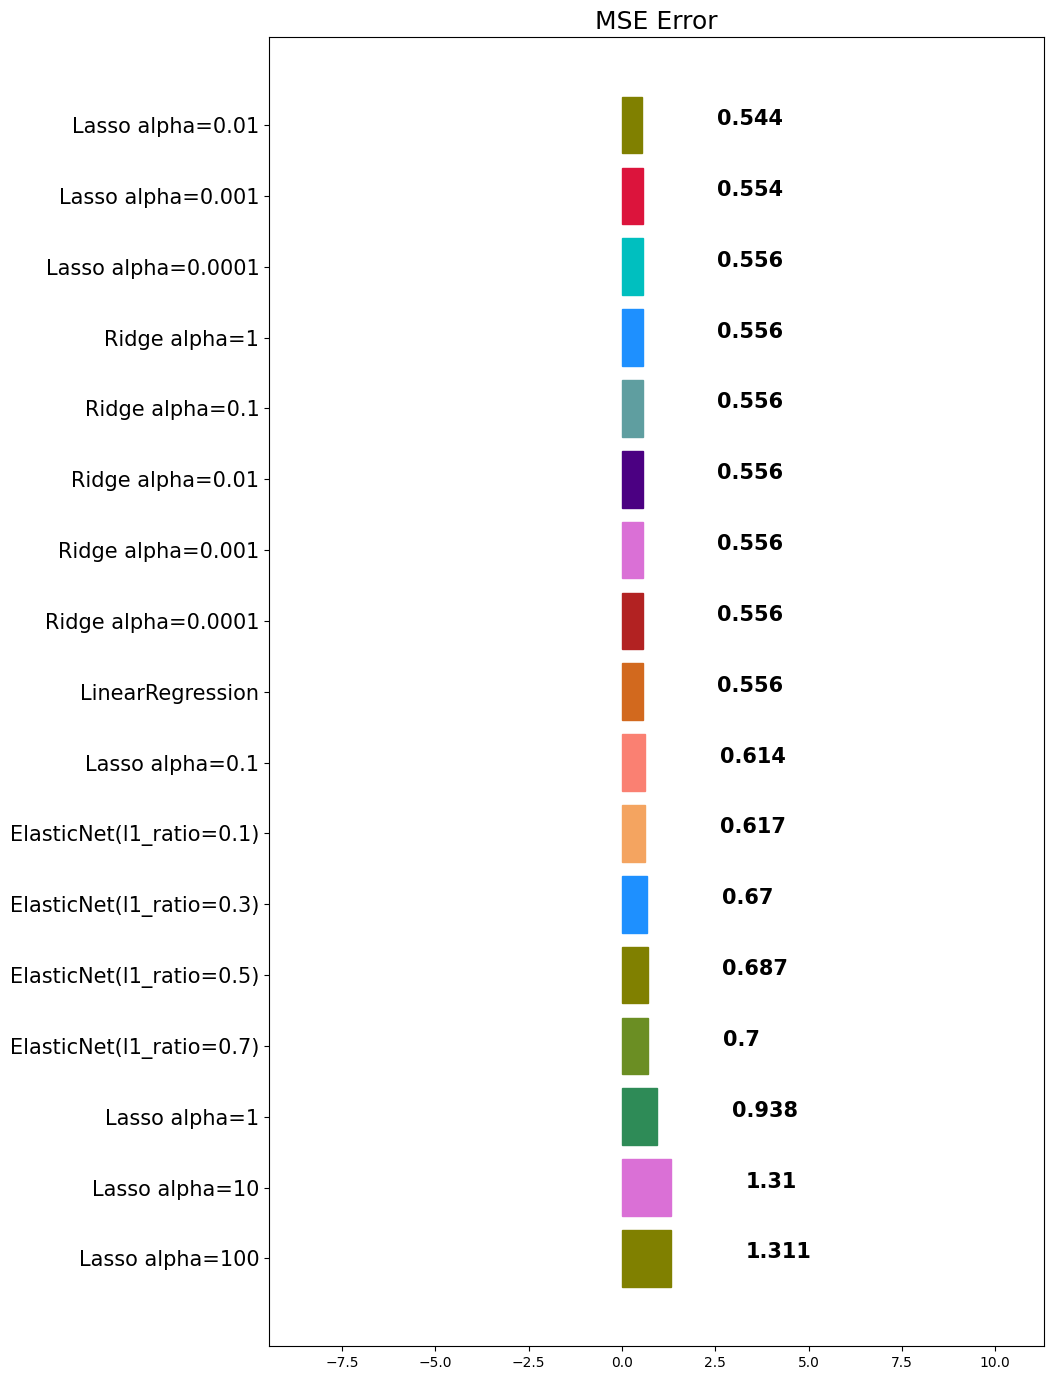

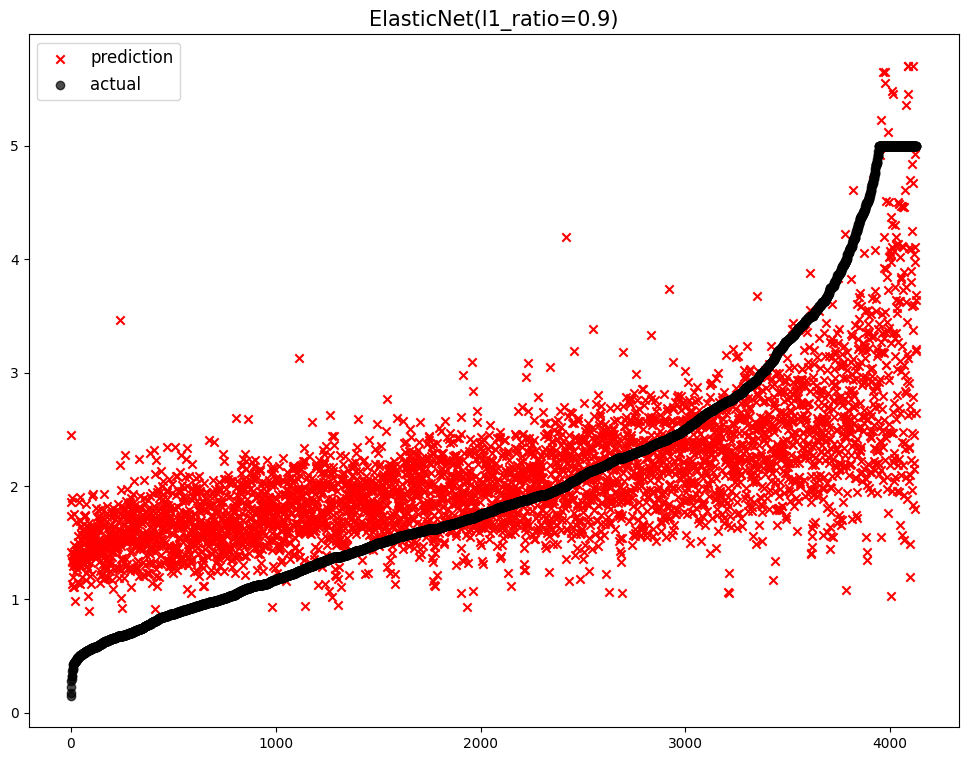

                       model       mse
0            Lasso alpha=100  1.310696
1             Lasso alpha=10  1.310227
2              Lasso alpha=1  0.938034
3   ElasticNet(l1_ratio=0.9)  0.716693
4   ElasticNet(l1_ratio=0.7)  0.700064
5   ElasticNet(l1_ratio=0.5)  0.686873
6   ElasticNet(l1_ratio=0.3)  0.670324
7   ElasticNet(l1_ratio=0.1)  0.616577
8            Lasso alpha=0.1  0.613512
9           LinearRegression  0.555892
10        Ridge alpha=0.0001  0.555892
11         Ridge alpha=0.001  0.555892
12          Ridge alpha=0.01  0.555891
13           Ridge alpha=0.1  0.555883
14             Ridge alpha=1  0.555803
15        Lasso alpha=0.0001  0.555683
16         Lasso alpha=0.001  0.553894
17          Lasso alpha=0.01  0.544449


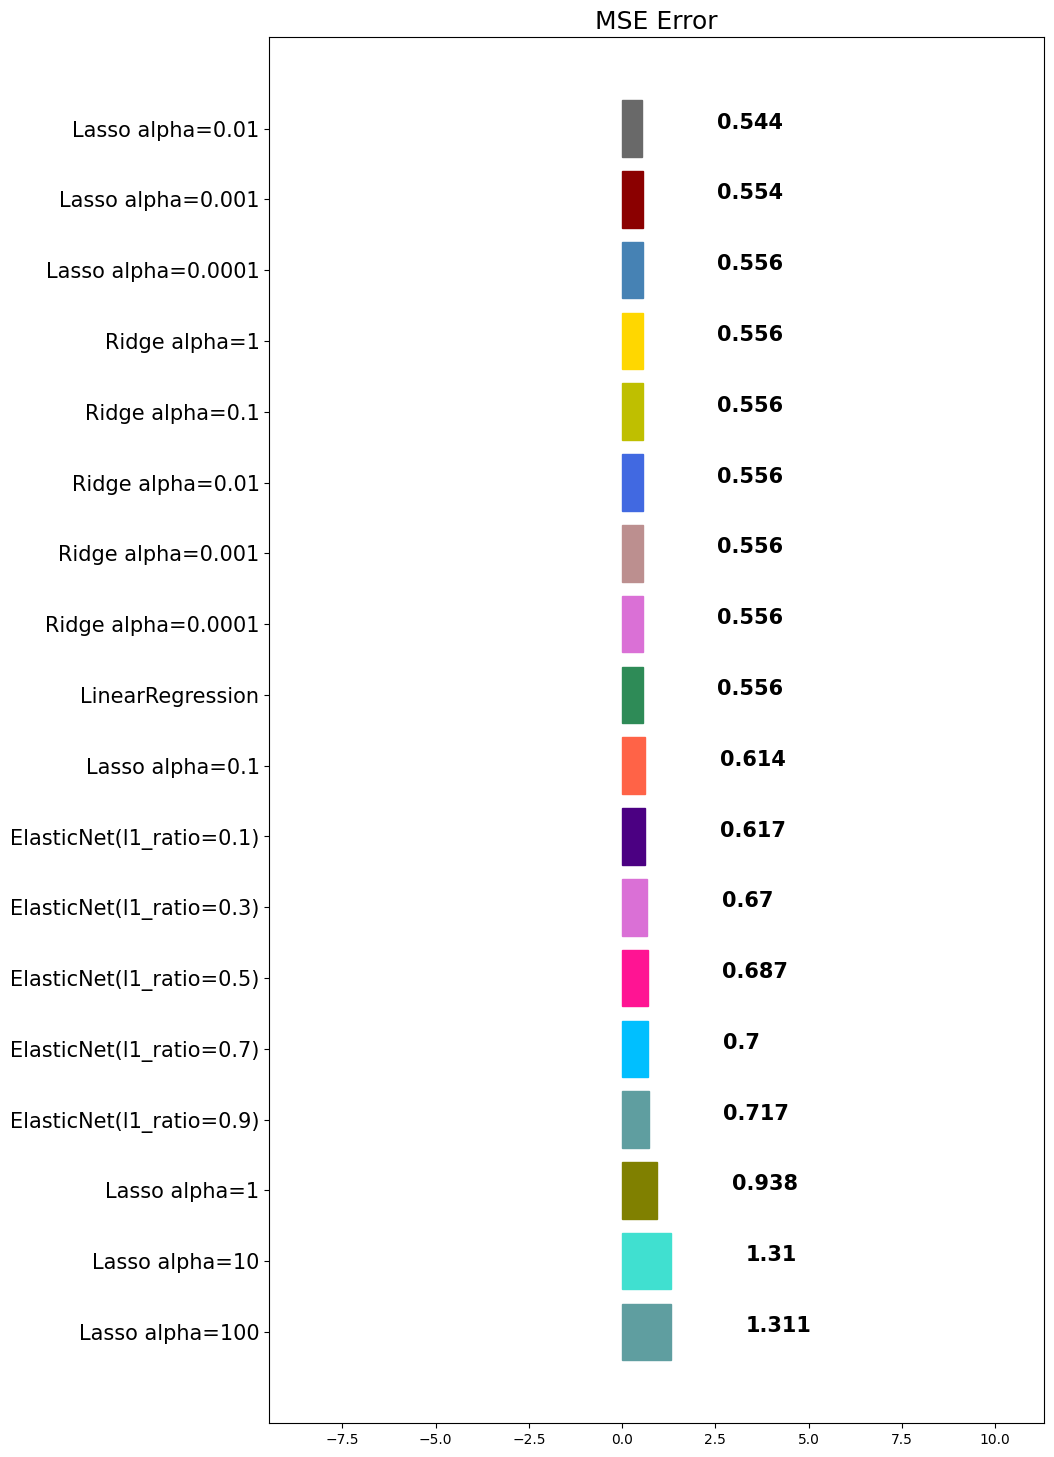

In [22]:
for ratio in ratios:
    elasticnet = ElasticNet(alpha=0.5, l1_ratio=ratio)
    elasticnet.fit(data_train, target_train)
    y_pred = elasticnet.predict(data_test)
    mse_eval('ElasticNet(l1_ratio={})'.format(ratio), y_pred, target_test)

### Scaler를 적용

In [23]:
# # data_train, data_test, target_train, target_test

# Outlier에 강한 스케일러 순서 : RobustScaler > StandardScaler > MinMaxScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

#데이터의 통계 분포
data_train.describe()

MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  16512.000000  16512.000000  16512.000000  16512.000000  16512.000000   
mean       3.880754     28.608285      5.435235      1.096685   1426.453004   
std        1.904294     12.602499      2.387375      0.433215   1137.056380   
min        0.499900      1.000000      0.888889      0.333333      3.000000   
25%        2.566700     18.000000      4.452055      1.006508    789.000000   
50%        3.545800     29.000000      5.235874      1.049286   1167.000000   
75%        4.773175     37.000000      6.061037      1.100348   1726.000000   
max       15.000100     52.000000    141.909091     25.636364  35682.000000   

           AveOccup      Latitude     Longitude  
count  16512.000000  16512.000000  16512.000000  
mean       3.096961     35.643149   -119.582290  
std       11.578744      2.136665      2.005654  
min        0.692308     32.550000   -124.350000  
25%        2.428799     33.930000   -121.810000  
50%        2.817240     34.260000   -118.510000  
75%        3.280000     37.720000   -118.010000  
max     1243.333333     41.950000   -114.310000

In [24]:
# StandardScaler를 사용하여 스케일링
std_scaler = StandardScaler()
std_scaled = std_scaler.fit_transform(data_train)

In [25]:
df_std_scaled =pd.DataFrame(data=std_scaled)
df_std_scaled.describe().round(4)

0           1           2           3           4           5  \
count  16512.0000  16512.0000  16512.0000  16512.0000  16512.0000  16512.0000   
mean      -0.0000     -0.0000      0.0000     -0.0000      0.0000      0.0000   
std        1.0000      1.0000      1.0000      1.0000      1.0000      1.0000   
min       -1.7754     -2.1908     -1.9044     -1.7621     -1.2519     -0.2077   
25%       -0.6901     -0.8418     -0.4118     -0.2082     -0.5606     -0.0577   
50%       -0.1759      0.0311     -0.0835     -0.1094     -0.2282     -0.0242   
75%        0.4687      0.6659      0.2621      0.0085      0.2634      0.0158   
max        5.8393      1.8562     57.1666     56.6473     30.1274    107.1164   

                6           7  
count  16512.0000  16512.0000  
mean       0.0000      0.0000  
std        1.0000      1.0000  
min       -1.4477     -2.3772  
25%       -0.8018     -1.1107  
50%       -0.6474      0.5347  
75%        0.9720      0.7840  
max        2.9518      2.6288

In [26]:
#MinMaxScaler
minmax_scaler = MinMaxScaler()

#데이터 변환
minmax_scaled = minmax_scaler.fit_transform(data_train)

print("Min-Max Scaling 결과:")
df_minmax_scaled =pd.DataFrame(data=minmax_scaled)
df_minmax_scaled.describe().round(4)

Min-Max Scaling 결과:


0           1           2           3           4           5  \
count  16512.0000  16512.0000  16512.0000  16512.0000  16512.0000  16512.0000   
mean       0.2332      0.5413      0.0322      0.0302      0.0399      0.0019   
std        0.1313      0.2471      0.0169      0.0171      0.0319      0.0093   
min        0.0000      0.0000      0.0000      0.0000      0.0000      0.0000   
25%        0.1425      0.3333      0.0253      0.0266      0.0220      0.0014   
50%        0.2101      0.5490      0.0308      0.0283      0.0326      0.0017   
75%        0.2947      0.7059      0.0367      0.0303      0.0483      0.0021   
max        1.0000      1.0000      1.0000      1.0000      1.0000      1.0000   

                6           7  
count  16512.0000  16512.0000  
mean       0.3291      0.4749  
std        0.2273      0.1998  
min        0.0000      0.0000  
25%        0.1468      0.2530  
50%        0.1819      0.5817  
75%        0.5500      0.6315  
max        1.0000      1.0000

In [27]:
#MinMaxScaler
robust_scaler = RobustScaler()

#데이터 변환
robust_scaled = robust_scaler.fit_transform(data_train)

print("Min-Max Scaling 결과:")
df_robust_scaled =pd.DataFrame(data=robust_scaled)
df_robust_scaled.describe().round(4)

Min-Max Scaling 결과:


0           1           2           3           4           5  \
count  16512.0000  16512.0000  16512.0000  16512.0000  16512.0000  16512.0000   
mean       0.1518     -0.0206      0.1239      0.5051      0.2769      0.3286   
std        0.8630      0.6633      1.4838      4.6165      1.2135     13.6028   
min       -1.3804     -1.4737     -2.7017     -7.6295     -1.2423     -2.4964   
25%       -0.4437     -0.5789     -0.4872     -0.4559     -0.4034     -0.4563   
50%        0.0000      0.0000     -0.0000      0.0000      0.0000      0.0000   
75%        0.5563      0.4211      0.5128      0.5441      0.5966      0.5437   
max        5.1912      1.2105     84.9439    262.0108     36.8356   1457.3714   

                6           7  
count  16512.0000  16512.0000  
mean       0.3649     -0.2822  
std        0.5638      0.5278  
min       -0.4512     -1.5368  
25%       -0.0871     -0.8684  
50%        0.0000      0.0000  
75%        0.9129      0.1316  
max        2.0290      1.1053

### 여러가지 조합을 만들기
make_pipeline를 사용하여 조합 만들기
1. StandardScaler + ElasticNet(l1_ratio=0.1)
2. RobustScaler + ElasticNet(l1_ratio=0.1)
3. MinMaxScaler + ElasticNet(l1_ratio=0.1)
4. 다항 회귀

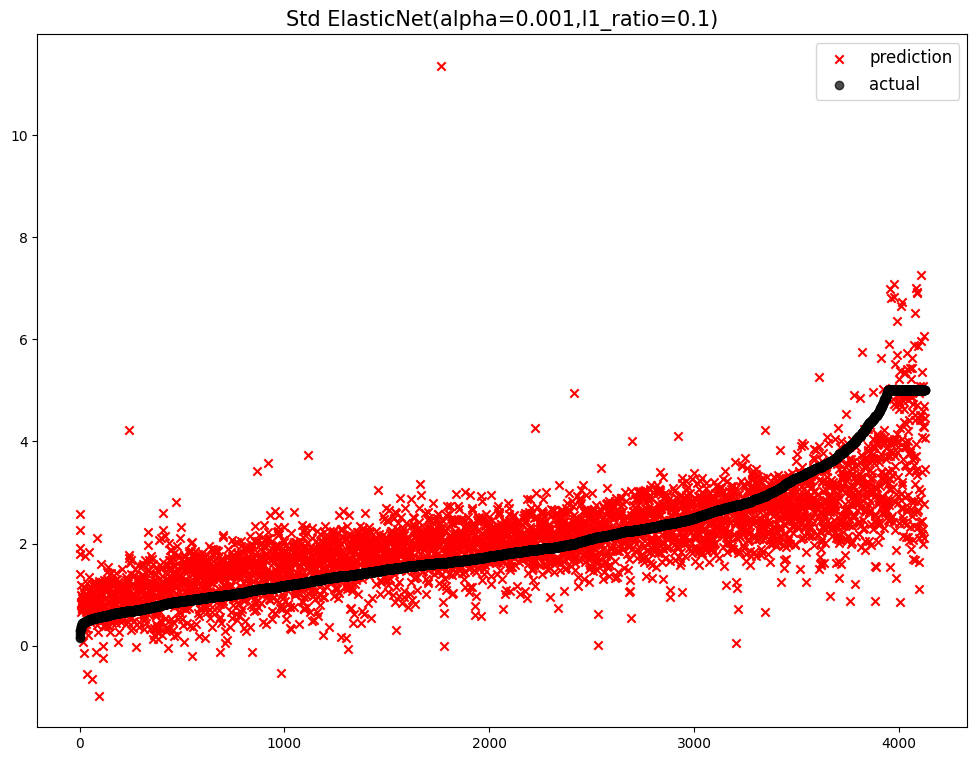

                                       model       mse
0                            Lasso alpha=100  1.310696
1                             Lasso alpha=10  1.310227
2                              Lasso alpha=1  0.938034
3                   ElasticNet(l1_ratio=0.9)  0.716693
4                   ElasticNet(l1_ratio=0.7)  0.700064
5                   ElasticNet(l1_ratio=0.5)  0.686873
6                   ElasticNet(l1_ratio=0.3)  0.670324
7                   ElasticNet(l1_ratio=0.1)  0.616577
8                            Lasso alpha=0.1  0.613512
9                           LinearRegression  0.555892
10                        Ridge alpha=0.0001  0.555892
11                         Ridge alpha=0.001  0.555892
12                          Ridge alpha=0.01  0.555891
13                           Ridge alpha=0.1  0.555883
14                             Ridge alpha=1  0.555803
15                        Lasso alpha=0.0001  0.555683
16  Std ElasticNet(alpha=0.001,l1_ratio=0.1)  0.555232
17        

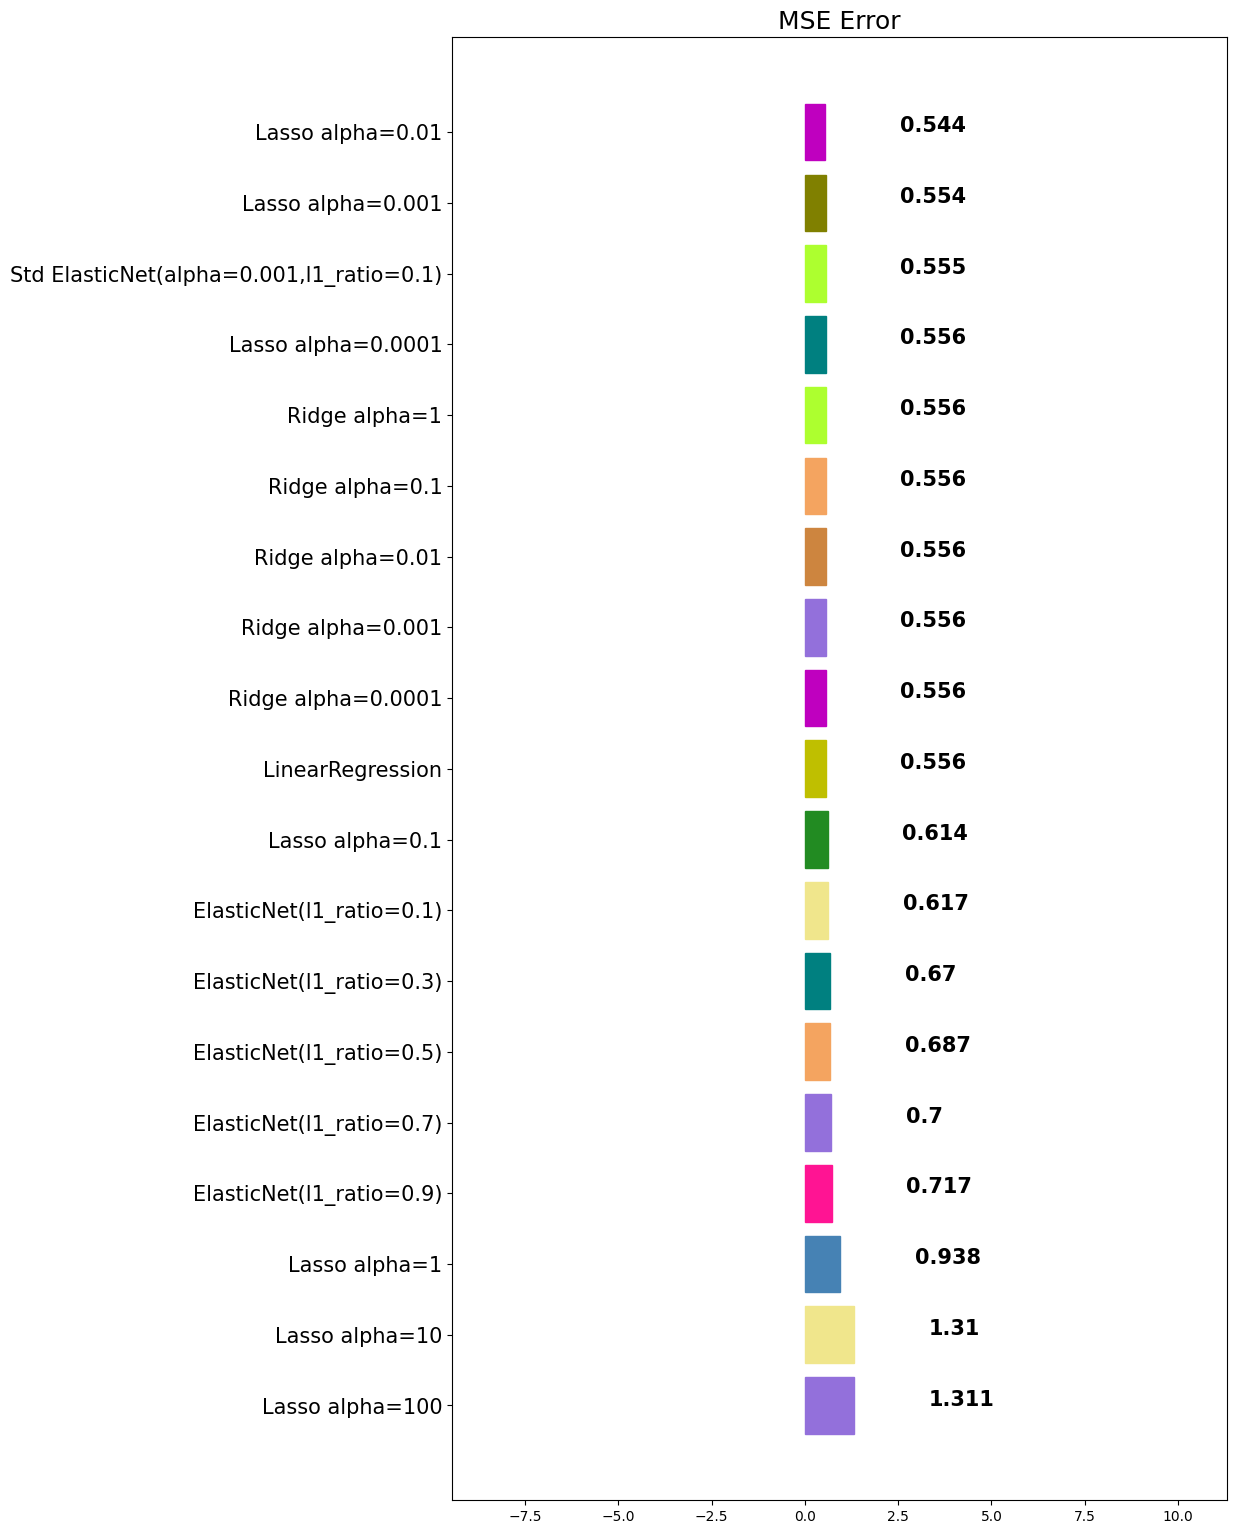

In [28]:
from sklearn.pipeline import Pipeline

# 1. 파이프라인(모델) 생성
std_scaled_elastic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter=10000))
])

# data_train, data_test, target_train, target_test

# 2. 파이프라인(모델) 학습
std_scaled_elastic_pipeline.fit(data_train, target_train)

# 3. 파이프라인 예측
y_pred = std_scaled_elastic_pipeline.predict(data_test)

# 4. 파이프라인 평가
mse_eval('Std ElasticNet(alpha=0.001,l1_ratio=0.1)', y_pred, target_test)

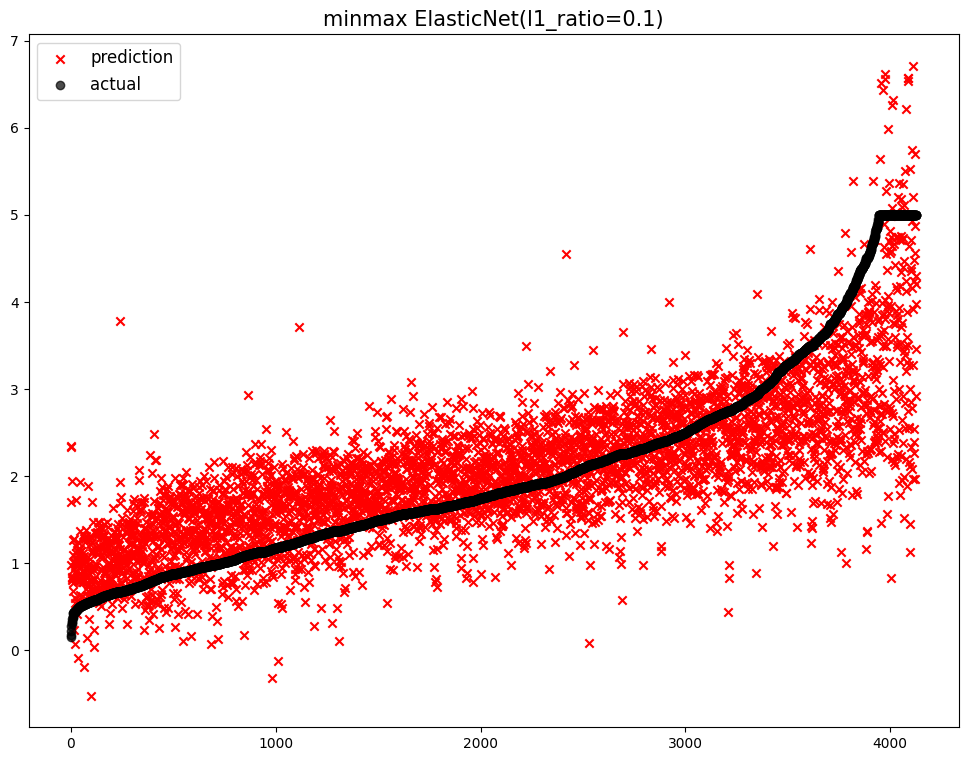

                                       model       mse
0                            Lasso alpha=100  1.310696
1                             Lasso alpha=10  1.310227
2                              Lasso alpha=1  0.938034
3                   ElasticNet(l1_ratio=0.9)  0.716693
4                   ElasticNet(l1_ratio=0.7)  0.700064
5                   ElasticNet(l1_ratio=0.5)  0.686873
6                   ElasticNet(l1_ratio=0.3)  0.670324
7                   ElasticNet(l1_ratio=0.1)  0.616577
8                            Lasso alpha=0.1  0.613512
9                           LinearRegression  0.555892
10                        Ridge alpha=0.0001  0.555892
11                         Ridge alpha=0.001  0.555892
12                          Ridge alpha=0.01  0.555891
13                           Ridge alpha=0.1  0.555883
14                             Ridge alpha=1  0.555803
15                        Lasso alpha=0.0001  0.555683
16  Std ElasticNet(alpha=0.001,l1_ratio=0.1)  0.555232
17        

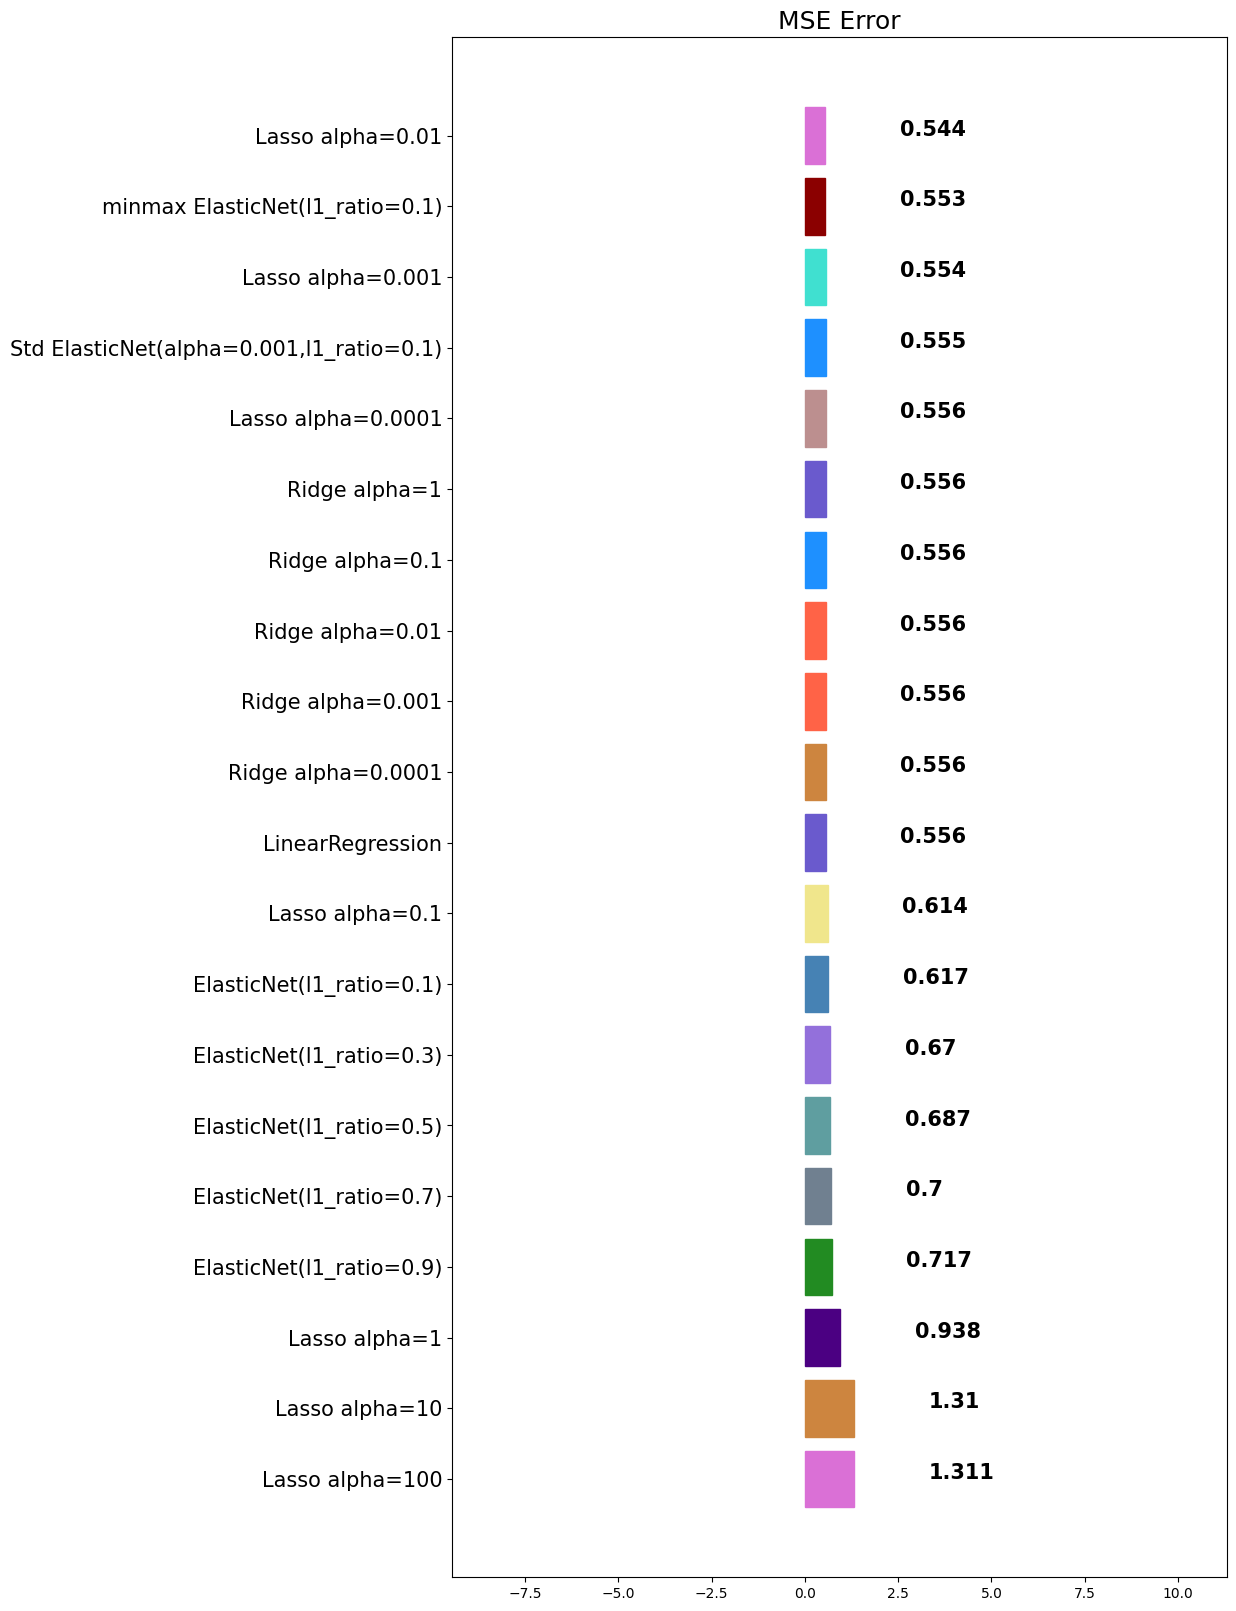

In [29]:
from sklearn.pipeline import Pipeline

# 1. 파이프라인(모델) 생성
minmax_scaled_elastic_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('elasticnet', ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter=10000))
])

# 2. 파이프라인(모델) 학습
minmax_scaled_elastic_pipeline.fit(data_train, target_train)

# 3. 파이프라인 예측
y_pred = minmax_scaled_elastic_pipeline.predict(data_test)

# 4. 파이프라인 평가
mse_eval('minmax ElasticNet(l1_ratio=0.1)', y_pred, target_test)